# Fermi/GBM Analysis of GRB 230307A

Let's start with the Fermi/GBM data, which is not highly affected by dead time and saturation.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-11-06 09:41:36,010]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1699260096.010455       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-06 09:41:36,011]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-06 09:41:36,019]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

### NaI Data

In [10]:
# read data
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")

# extract events
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc.dt * lc.counts
counts_obs_corr = lc.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc = Lightcurve(lc.time-lc.time[0], counts_obs_corr-mean_bkg)
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-06 09:43:00,726]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-11-06 09:43:00,727]: make_lightcurve: timebin:  2899
INFO[2023-11-06 09:43:00,772]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-06 09:43:00,773]: Checking if light curve is sorted.
INFO[2023-11-06 09:43:00,774]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


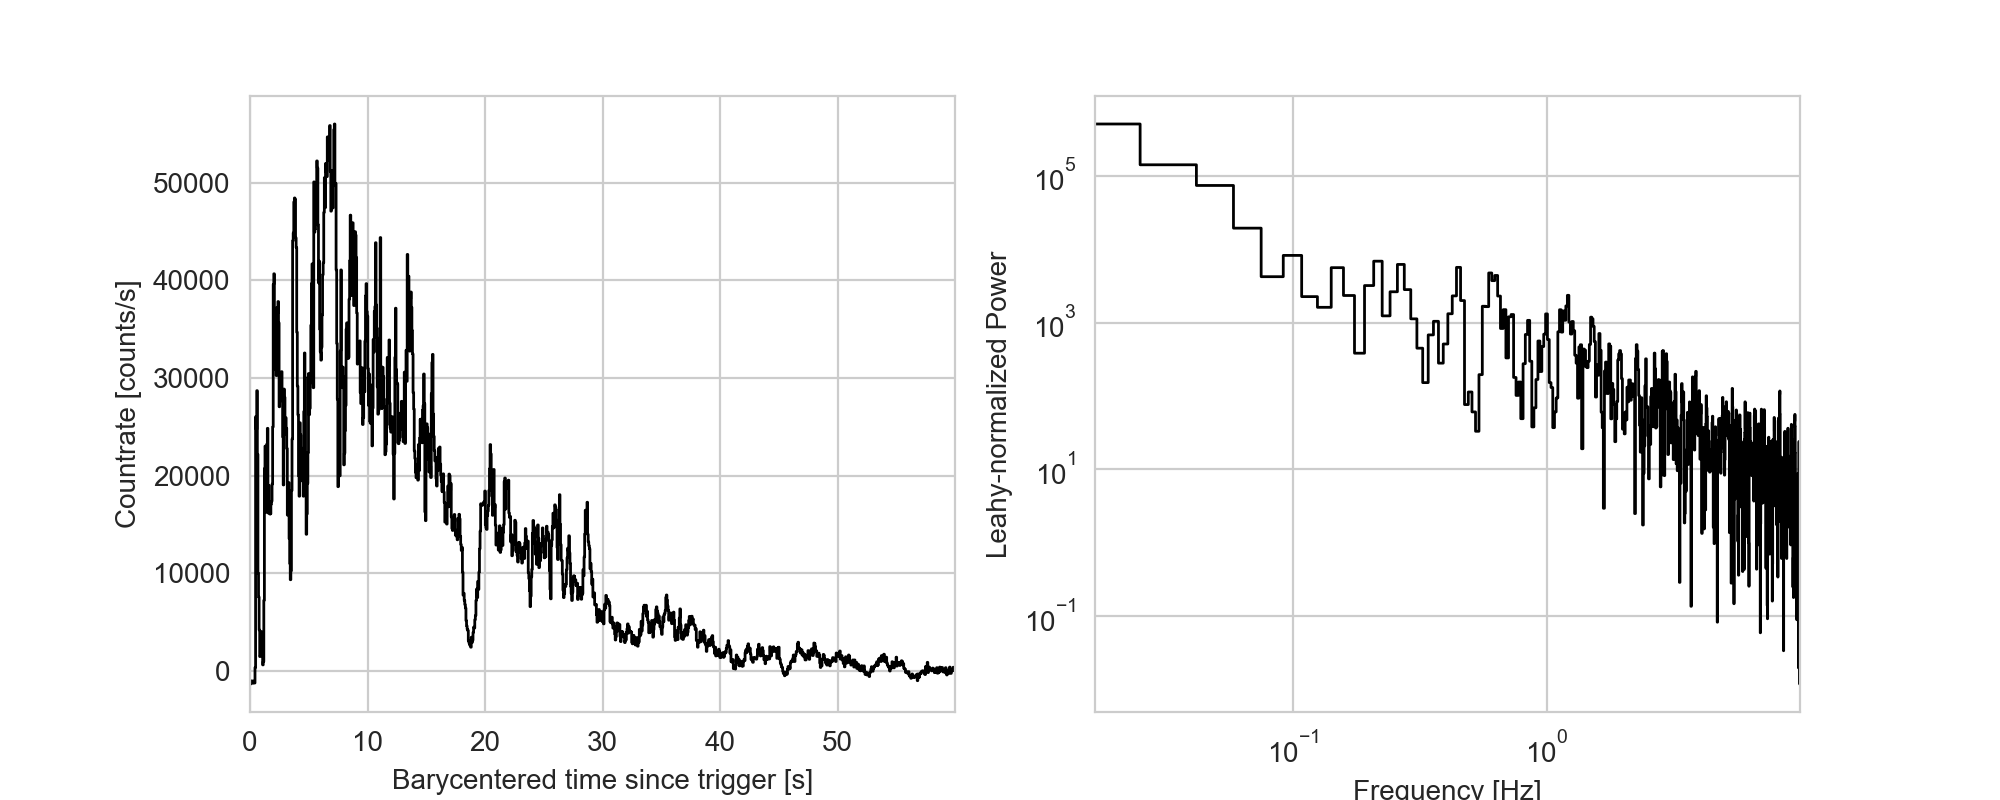

Text(0, 0.5, 'Leahy-normalized Power')

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## Gaussian Process Analysis on the Full Light Curve

Let's do the GP Analysis on the full light curve. We start by comparing a Damped Random Walk with a QPO model:

In [12]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [13]:
times = lc.time - lc.time[0]
counts = lc.counts

In [14]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [15]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

INFO[2023-11-06 09:43:22,361]: Sanity check...
INFO[2023-11-06 09:43:23,079]: Sanity check passed


Simulation Complete


In [16]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -7542.558665594181


In [11]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -7368.068985422507


In [17]:
with open(datadir+"fermi_na_drw_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)

In [18]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1287695
# samples: 13500
# slices: 207000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 95.4
# likelihood evals / slice: 6.2
--------
logZ=-7542.56 +- 0.19
H=7500.0
ESS=1693
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.45 +- 0.054 | 7.38 / 7.451 / 7.519 | 7.456 | 7.456
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 11.32 +- 0.13 | 11.15 / 11.31 / 11.49 | 11.29 | 11.29
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.79 +- 0.14 | 0.61 / 0.8 / 0.97 | 0.82 | 0.82
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: 0.18 +- 0.46 | -0.36 / 0.12 / 0.83 | -0.18 | -0.18
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.653 +- 0.094 | 2.544 / 2.663 / 2.756 | 

<IPython.core.display.Javascript object>


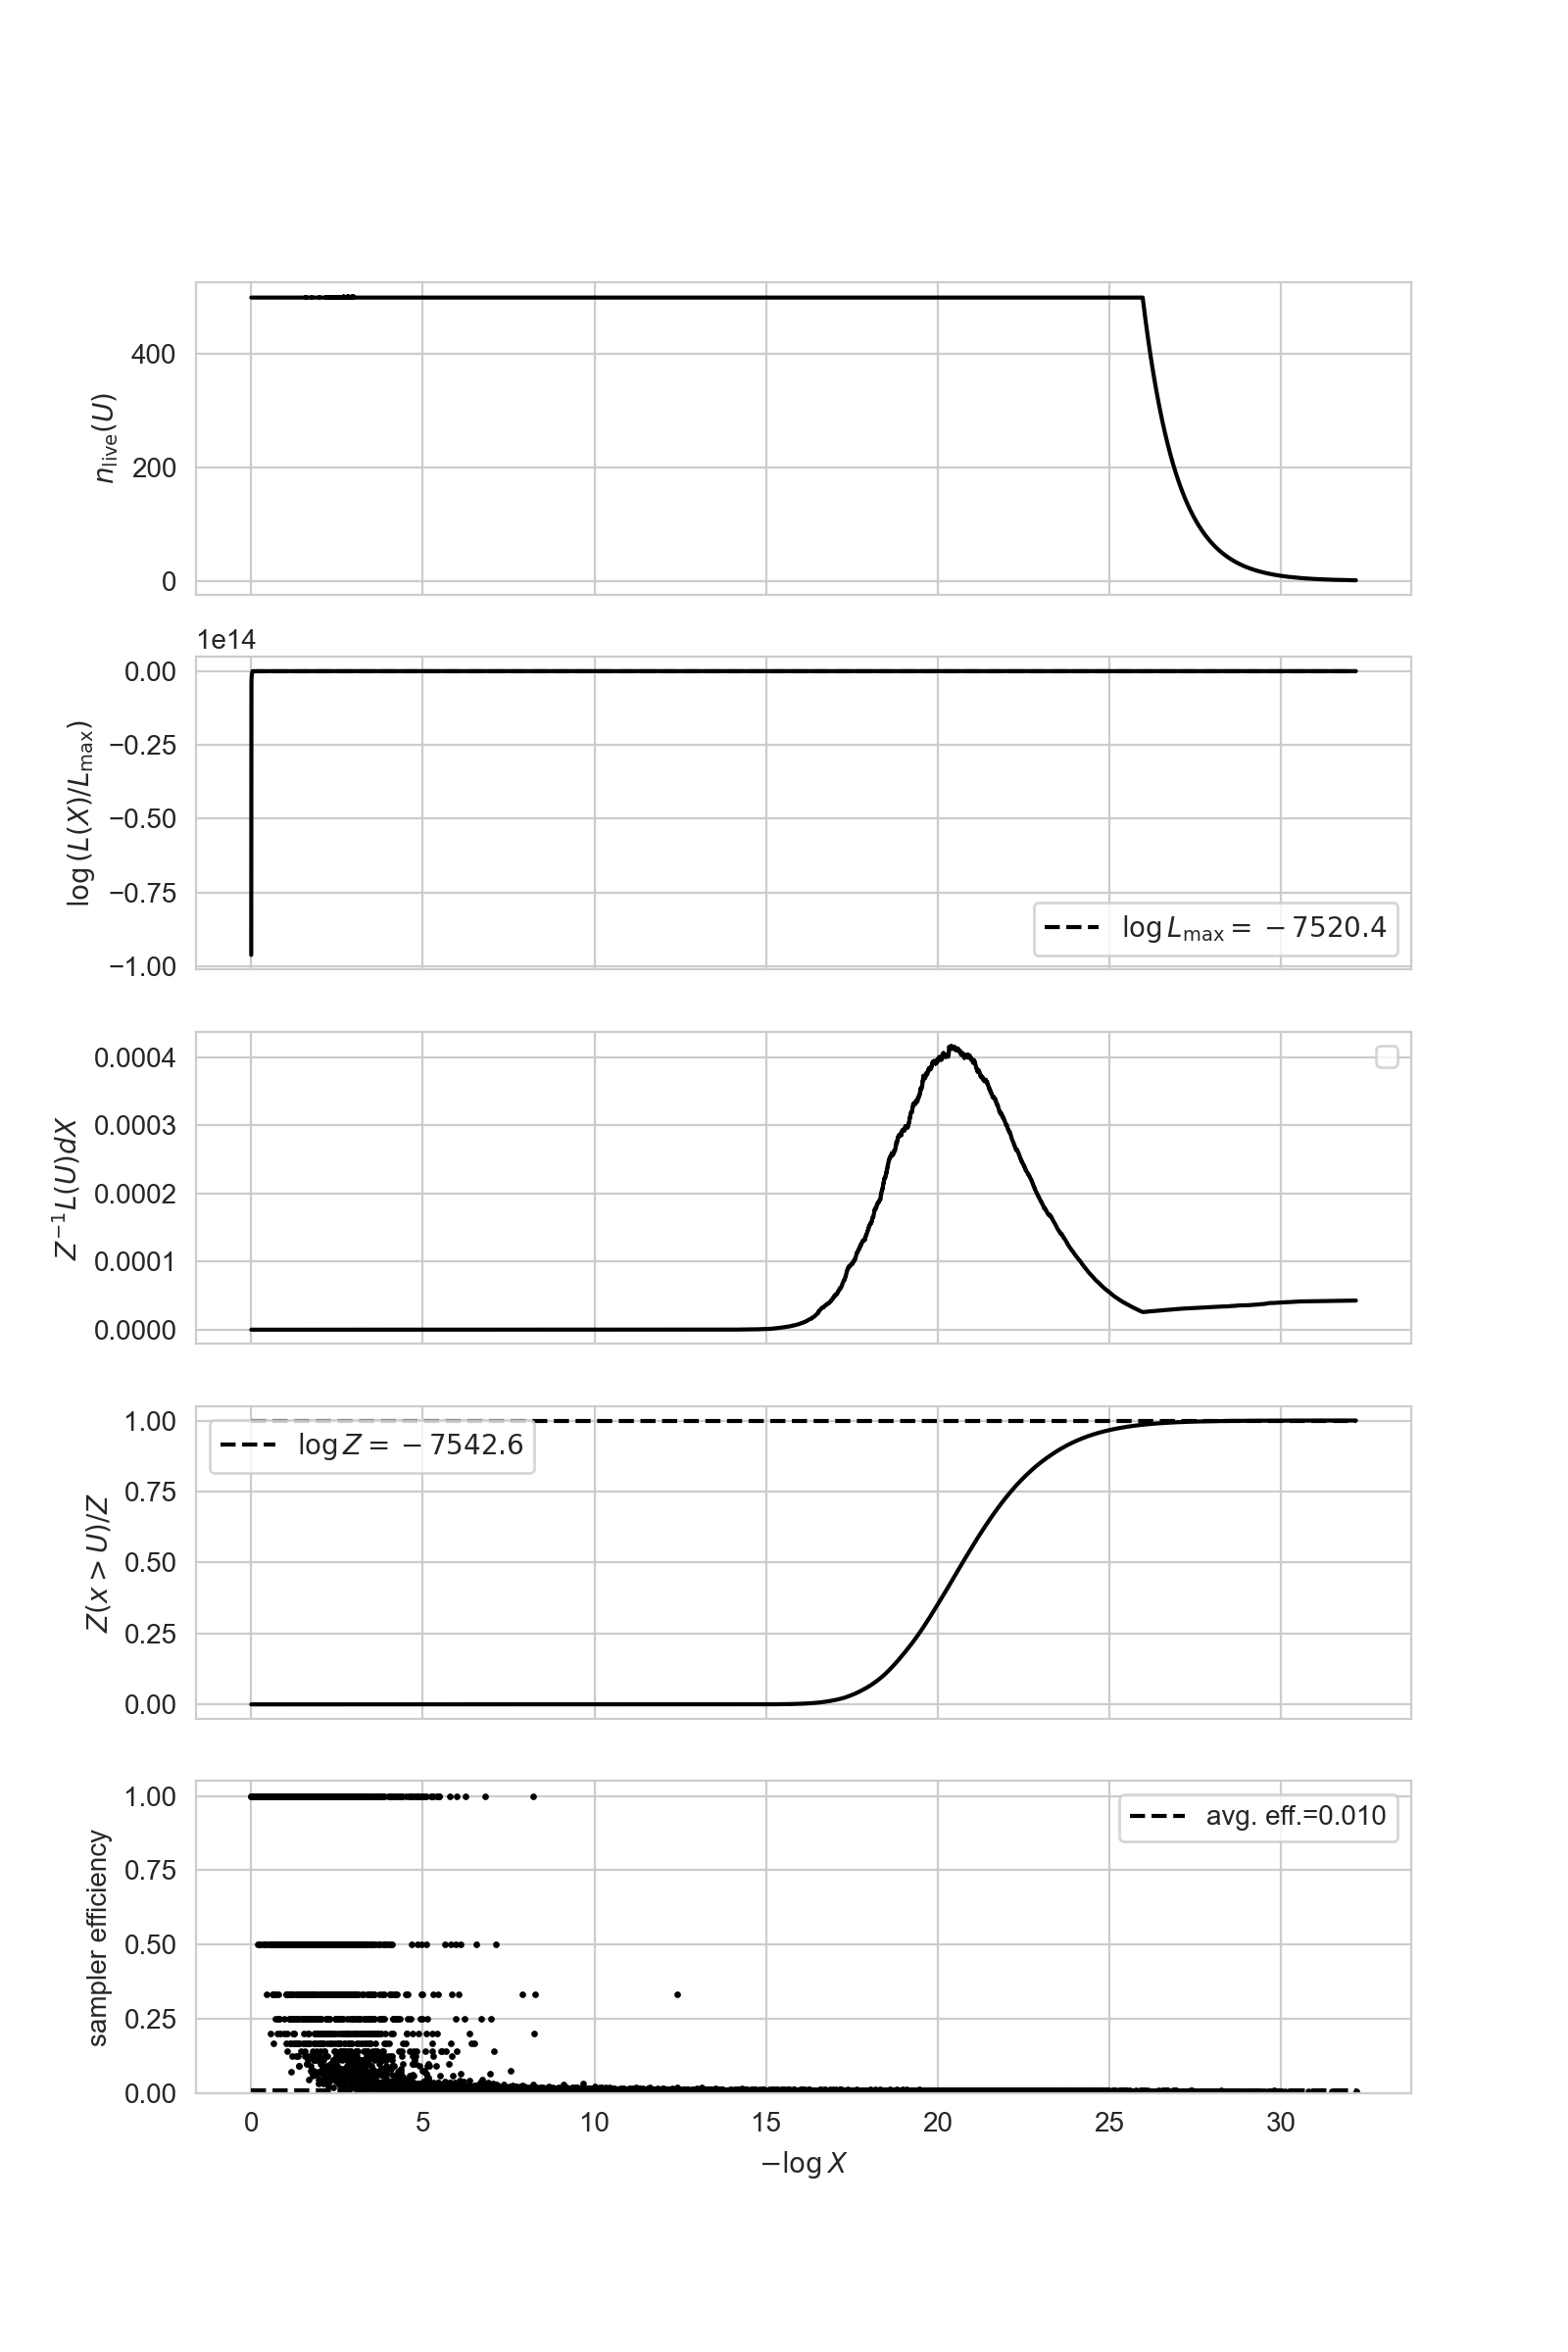

WARNING[2023-11-06 11:00:34,122]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [19]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


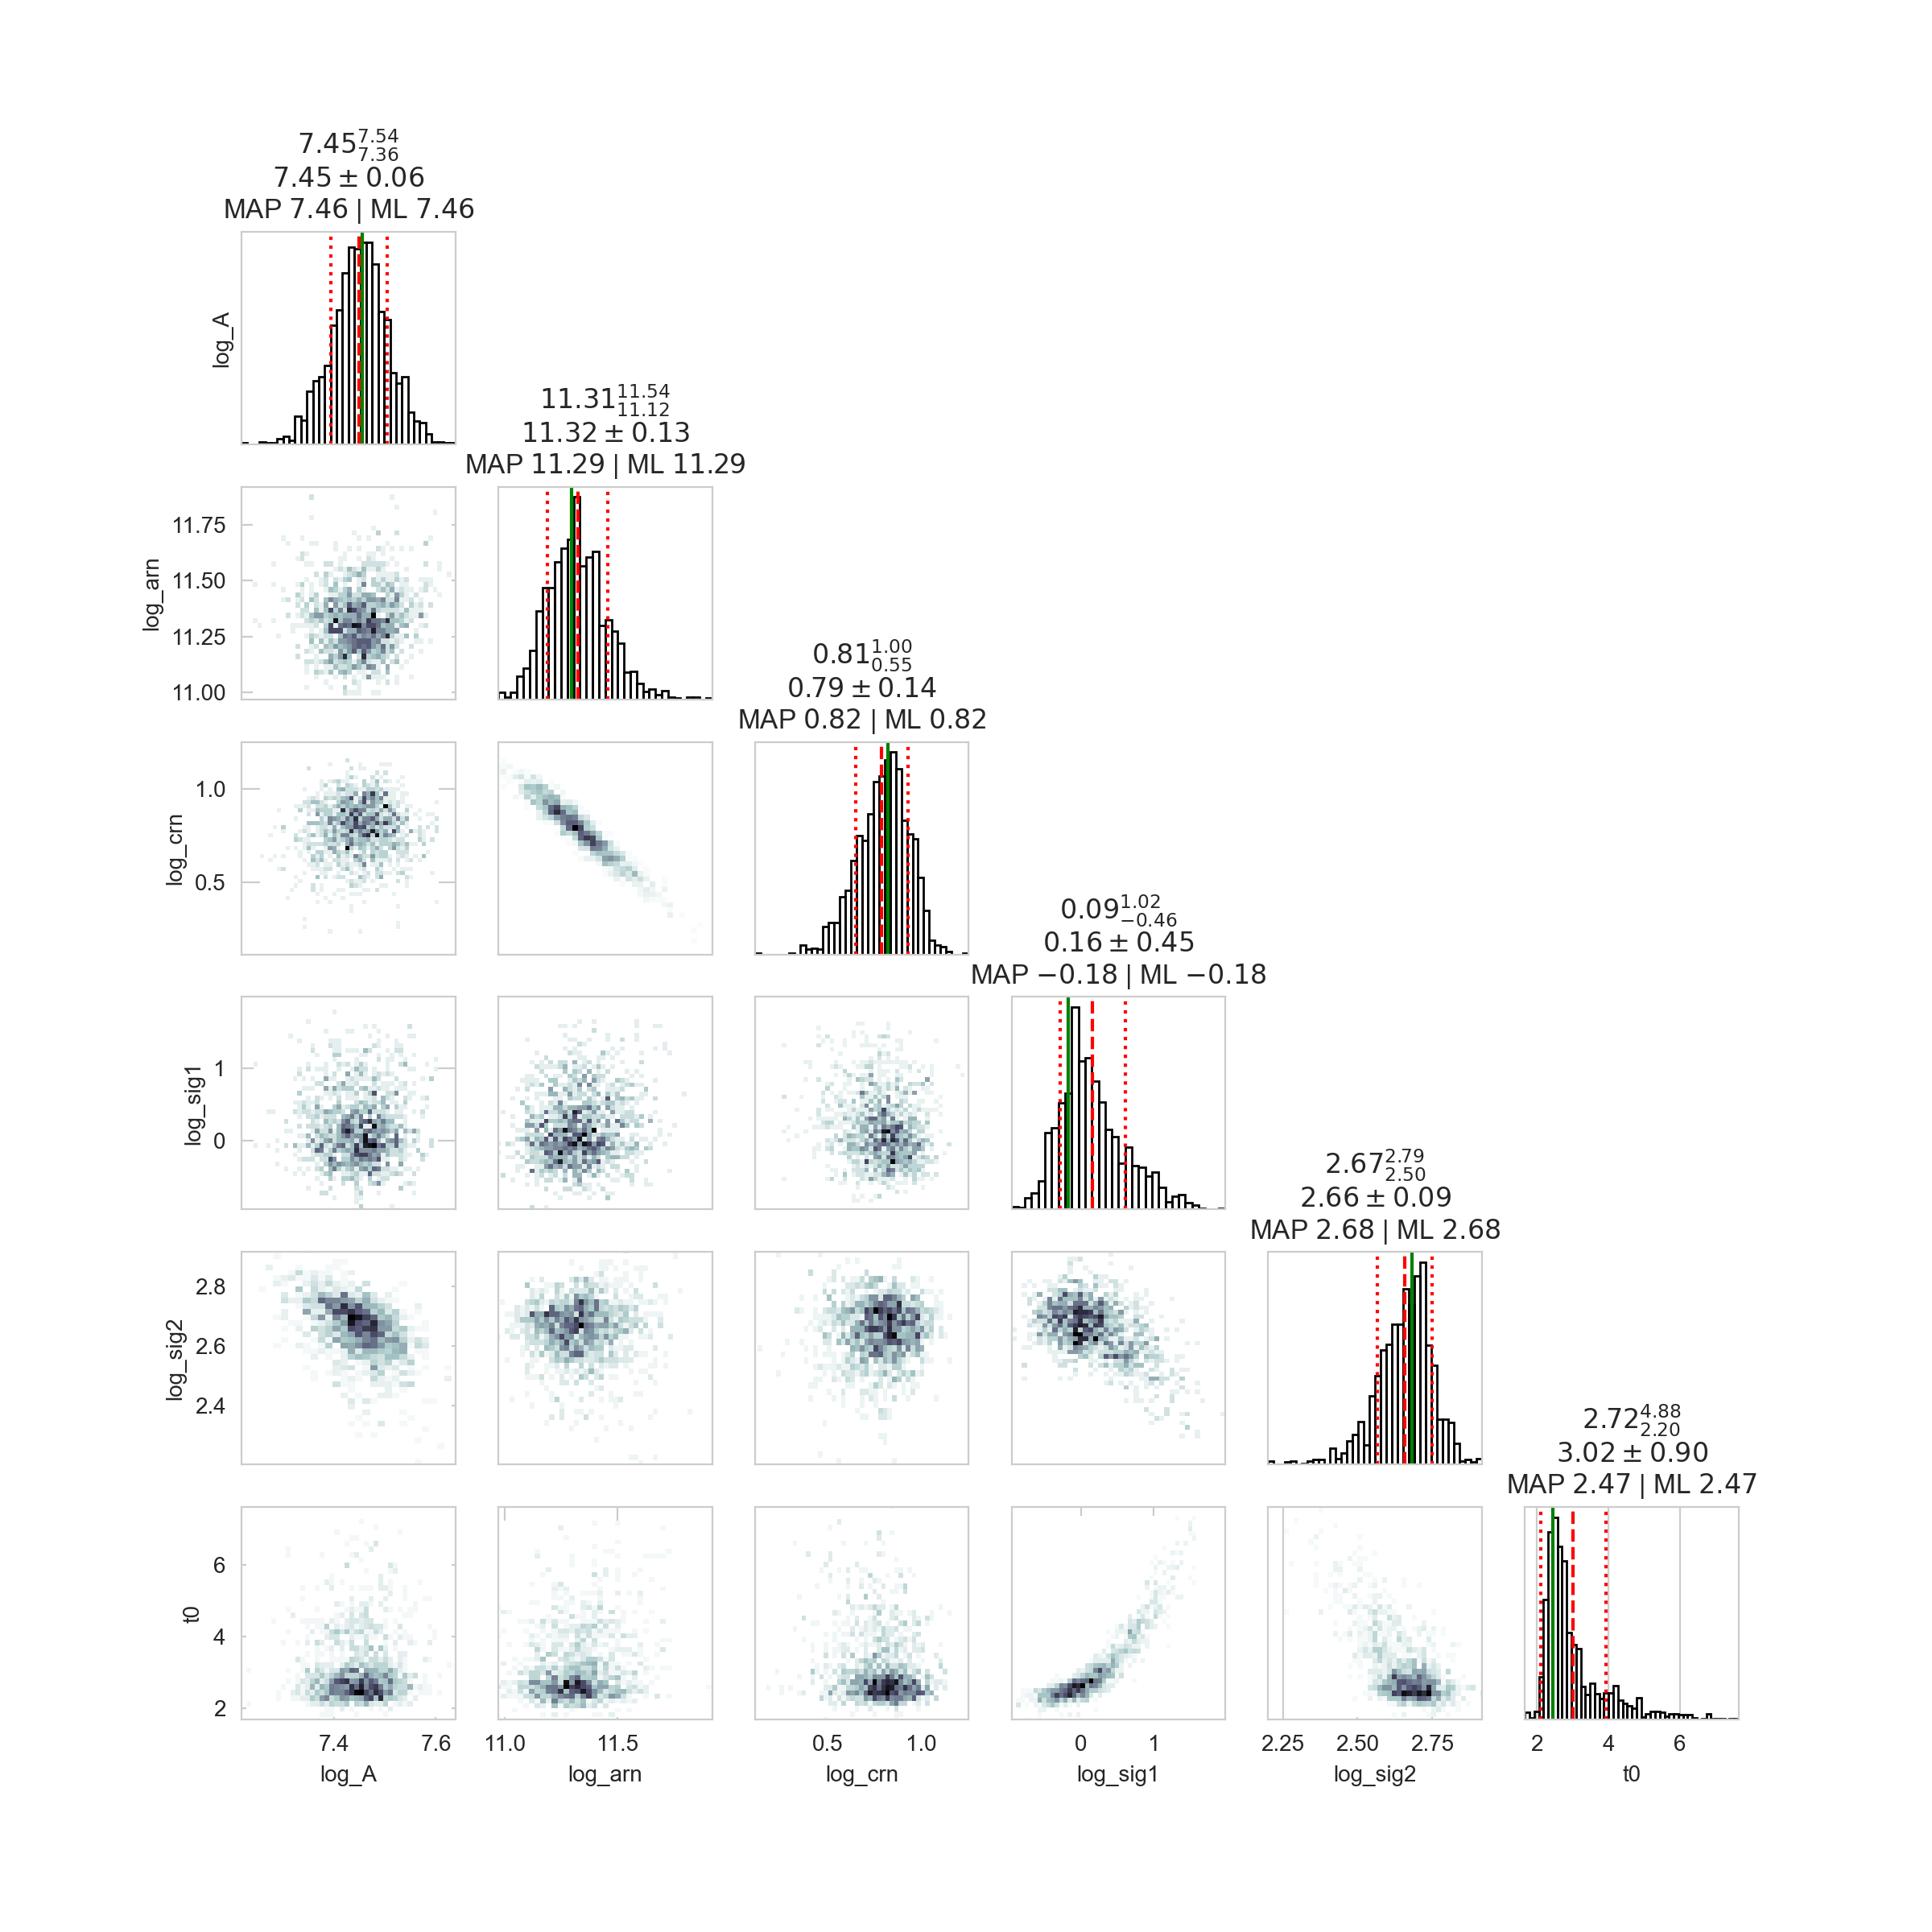

In [20]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [21]:
def plot_posterior_predictive(lc, gpresult, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = gpresult.results.log_dp_mean #log-prob
    nsamples = gpresult.results.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in gpresult.results.samples.keys():
        samples = gpresult.results.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(gpresult.results.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = gpresult.get_max_posterior_parameters()

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(gpresult.results.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(times)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(times, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(times, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

<IPython.core.display.Javascript object>


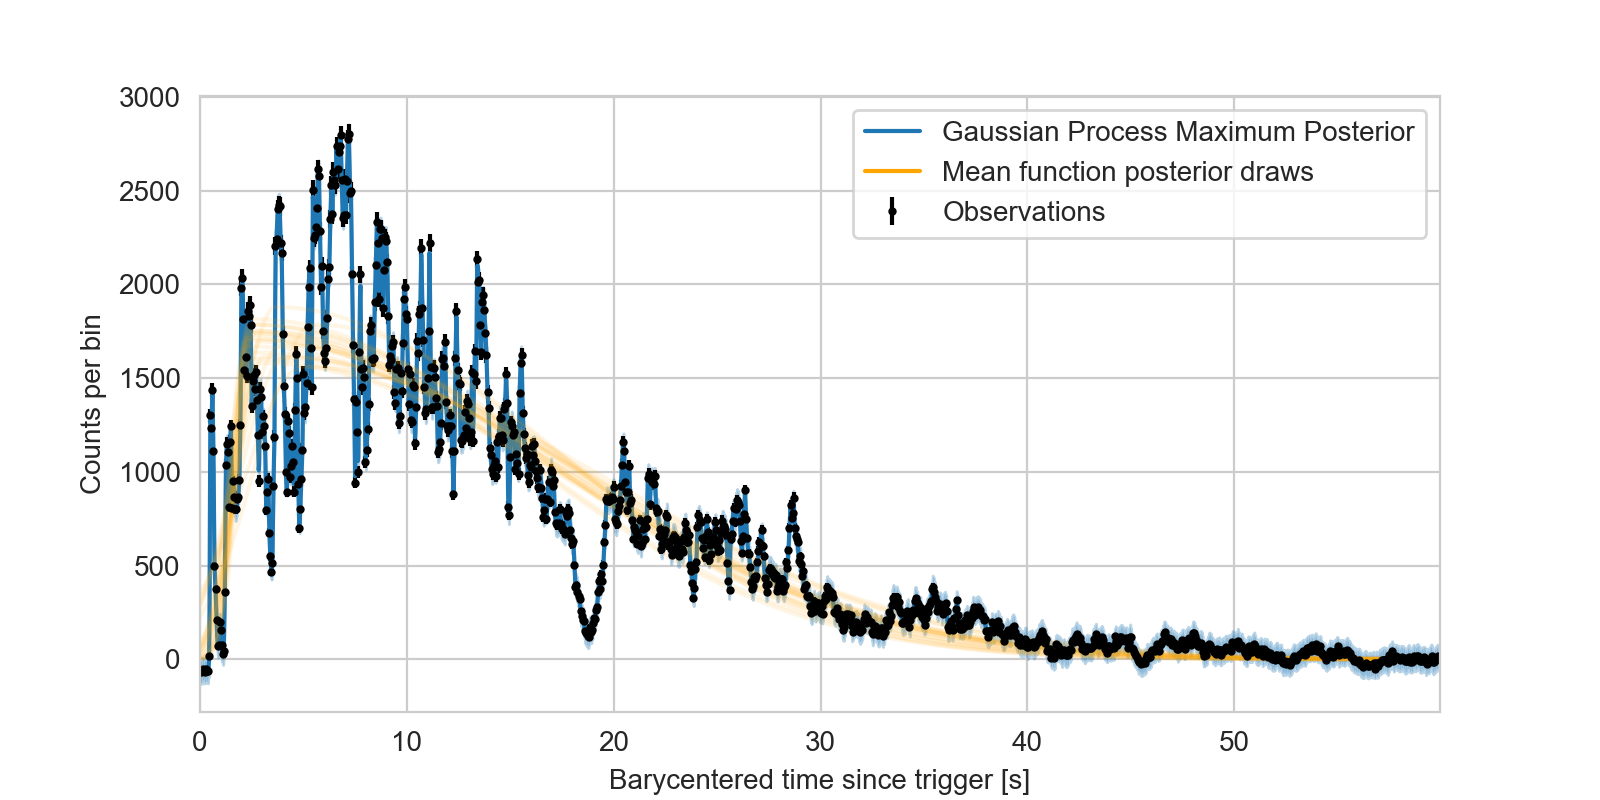

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [23]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [24]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [25]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2000)

INFO[2023-11-06 11:01:35,592]: Sanity check...
INFO[2023-11-06 11:01:35,898]: Sanity check passed


Simulation Complete


In [27]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -7542.558665594181


In [28]:
print("log Evidence: ", gpresult_qporn.get_evidence())

log Evidence:  -7538.3114432894


In [29]:
gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()

Array(4.2472223, dtype=float64)

In [30]:
with open(datadir+"fermi_nai_drw_qpo_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [31]:
gpresult_qporn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 8980736
# samples: 66000
# slices: 1512000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 136.1
# likelihood evals / slice: 5.9
--------
logZ=-7538.31 +- 0.11
H=7500.0
ESS=9130
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.446 +- 0.057 | 7.378 / 7.449 / 7.515 | 7.472 | 7.472
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 9.5 +- 1.1 | 8.4 / 9.4 / 10.7 | 9.0 | 9.0
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 11.22 +- 0.24 | 11.05 / 11.23 / 11.43 | 11.24 | 11.24
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -3.0 +- 2.1 | -5.4 / -3.3 / 0.7 | -3.0 | -3.0
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.71 +- 0.44 | 0.51 / 0.8 / 0.97 | 0.83 | 0.83


<IPython.core.display.Javascript object>


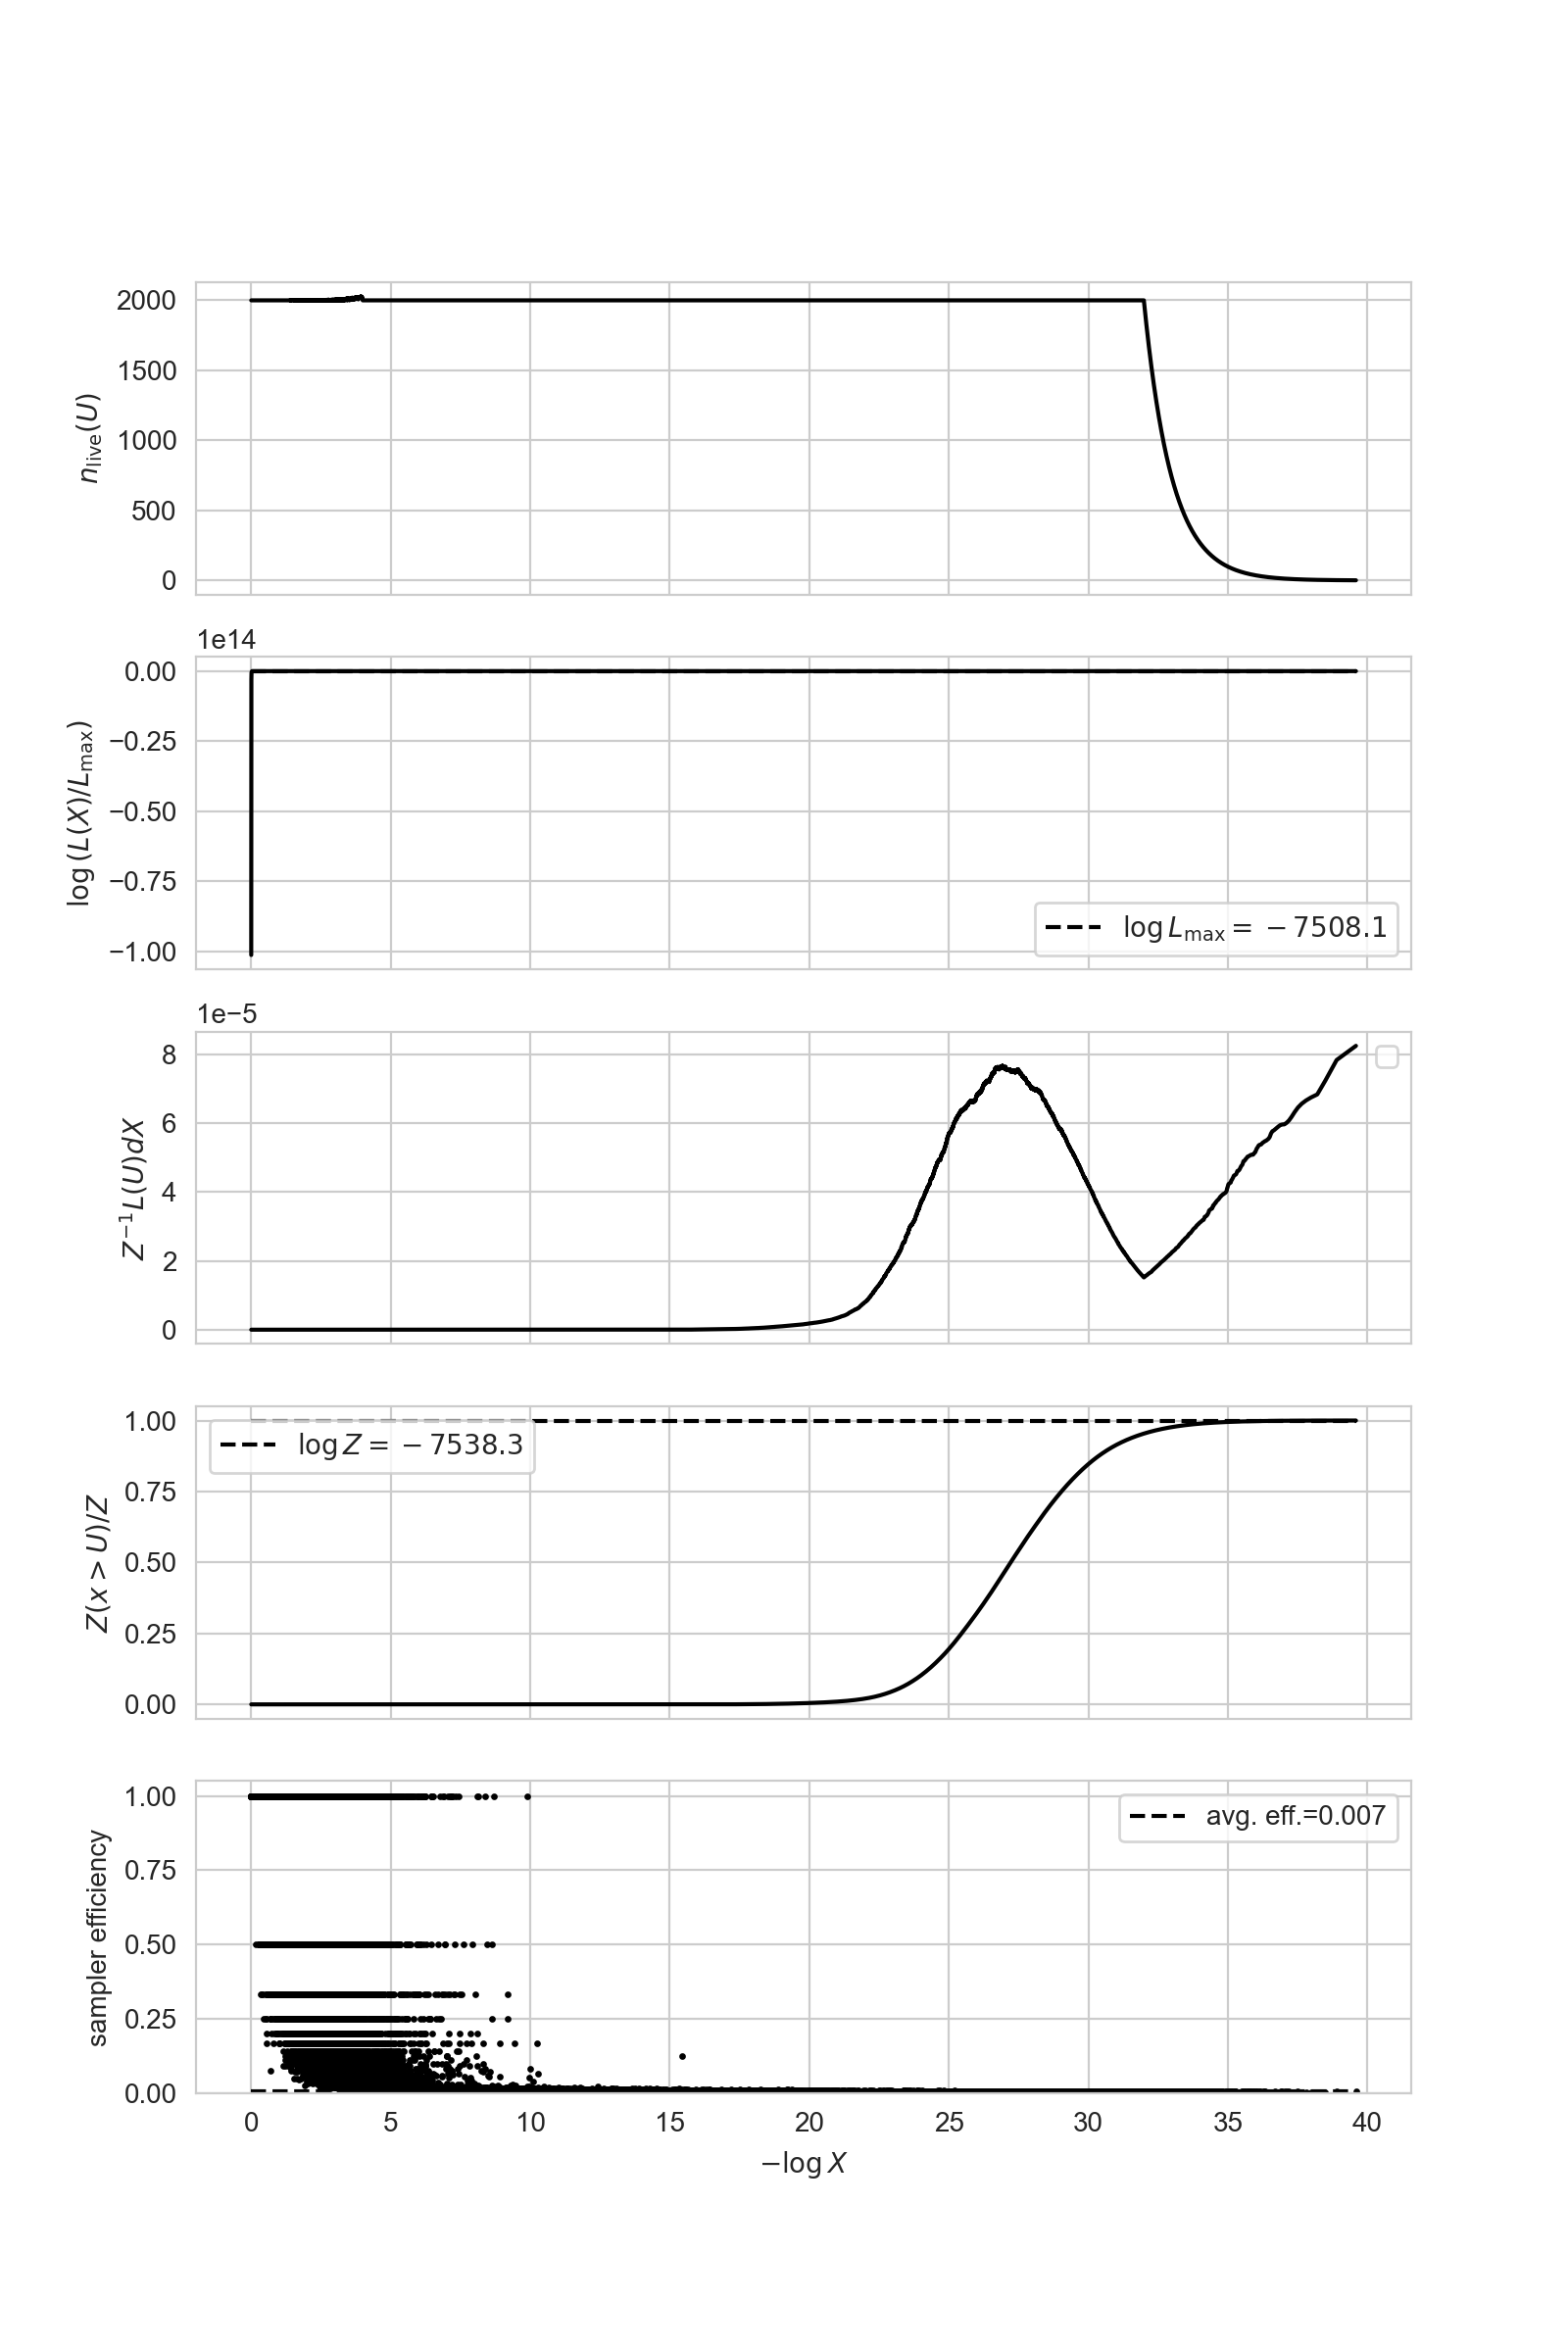

WARNING[2023-11-06 12:07:01,531]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [32]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


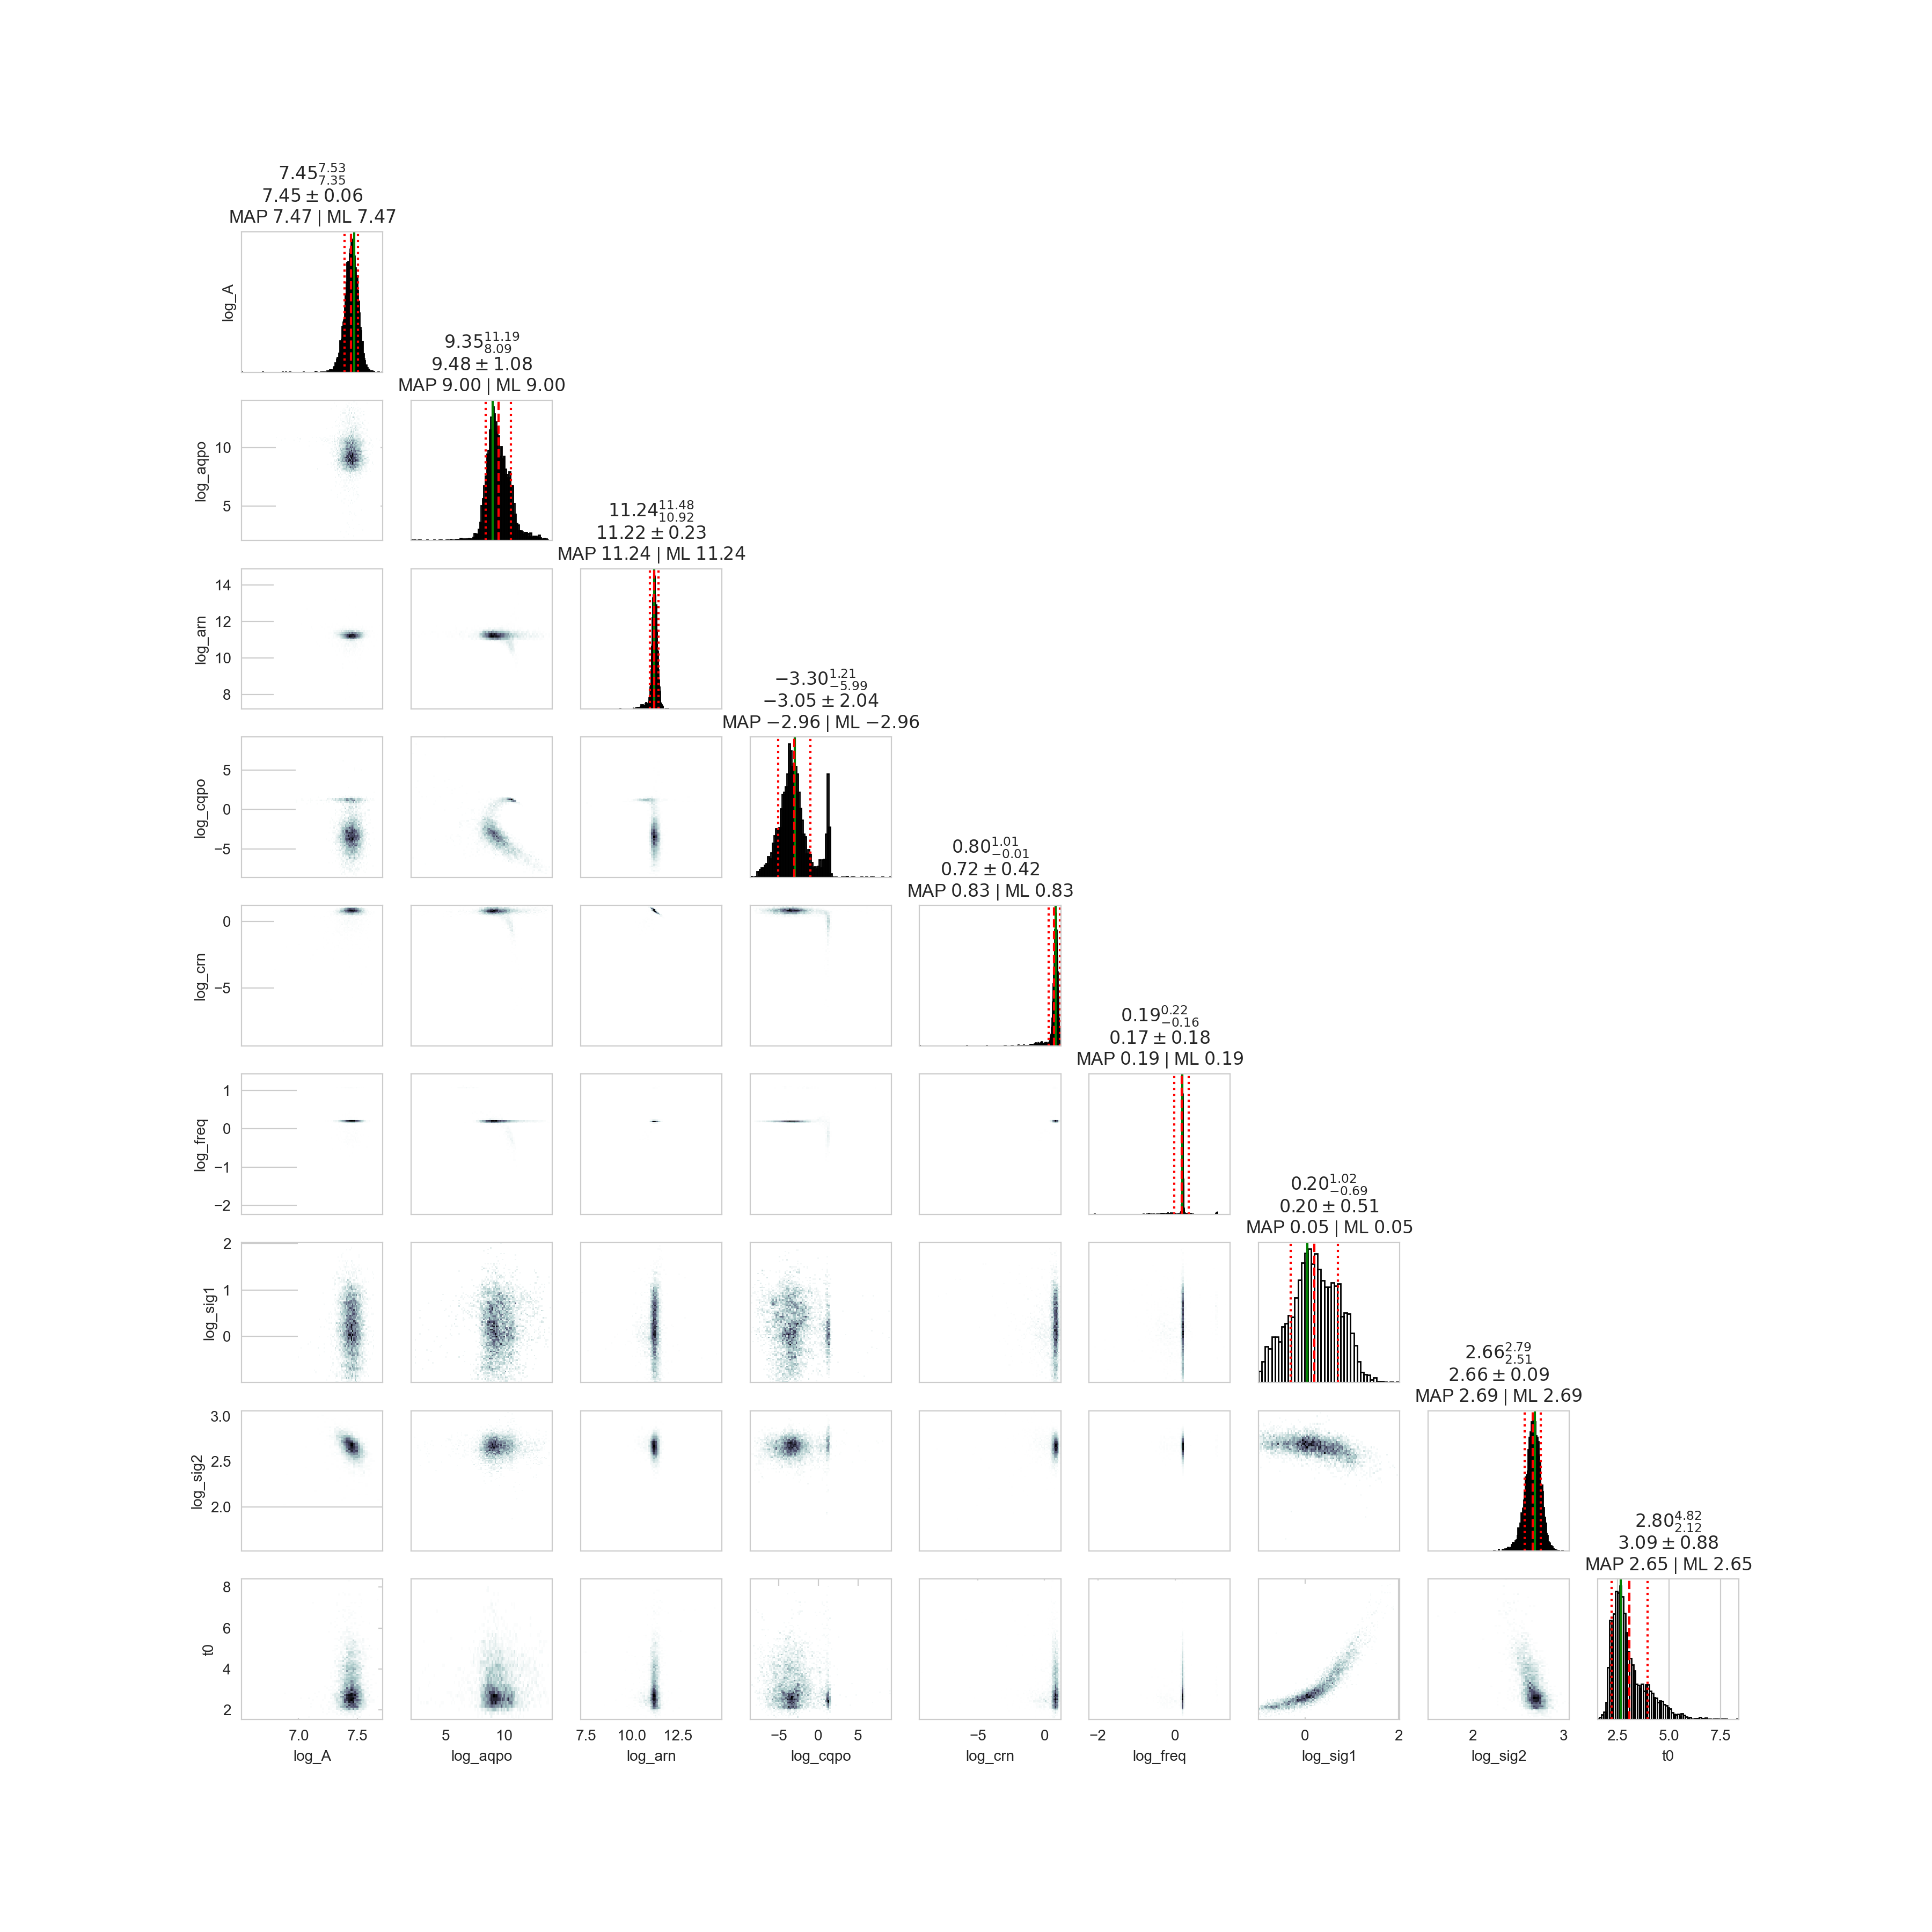

In [33]:
gpresult_qporn.plot_cornerplot()

<IPython.core.display.Javascript object>


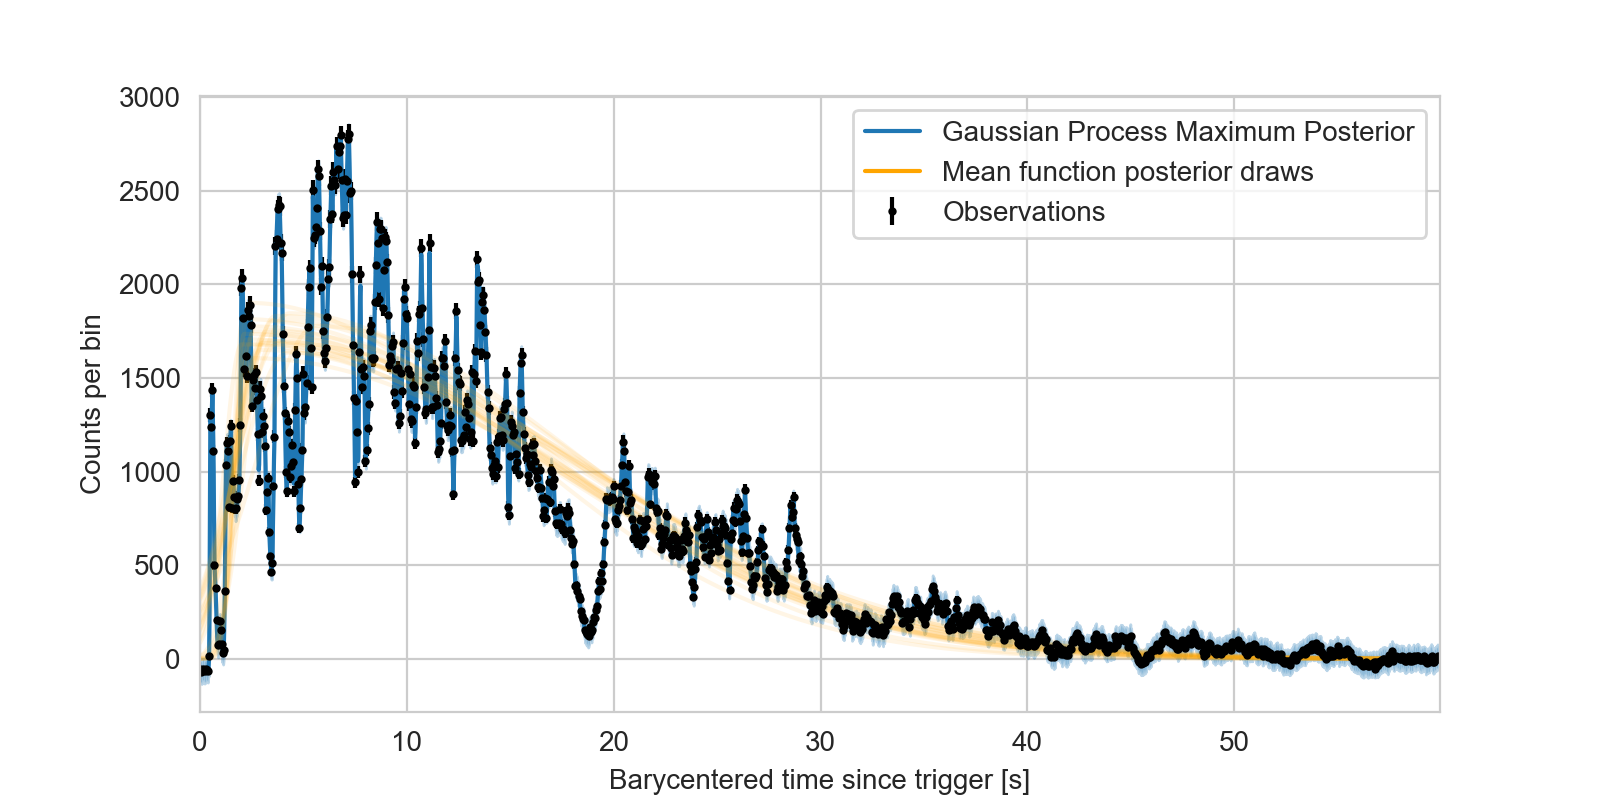

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [35]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [36]:
freq = np.exp(freq_resampled)
period = 1.0/freq

<IPython.core.display.Javascript object>


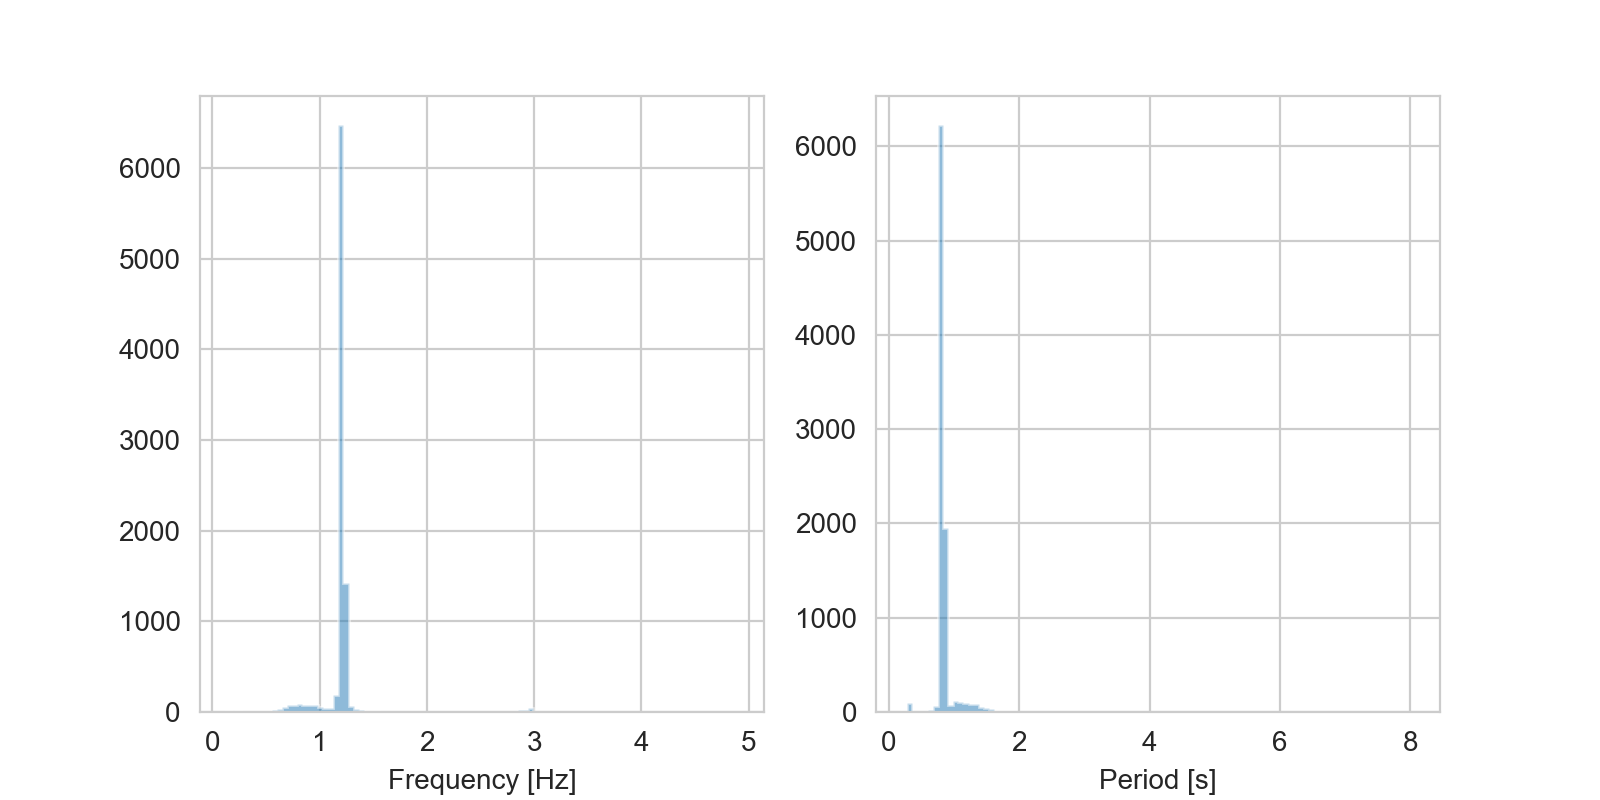

Text(0.5, 0, 'Period [s]')

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [38]:
np.log10(np.exp(gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()))

1.8445452103826843

## Cutting Out the Saturated Parts

<IPython.core.display.Javascript object>


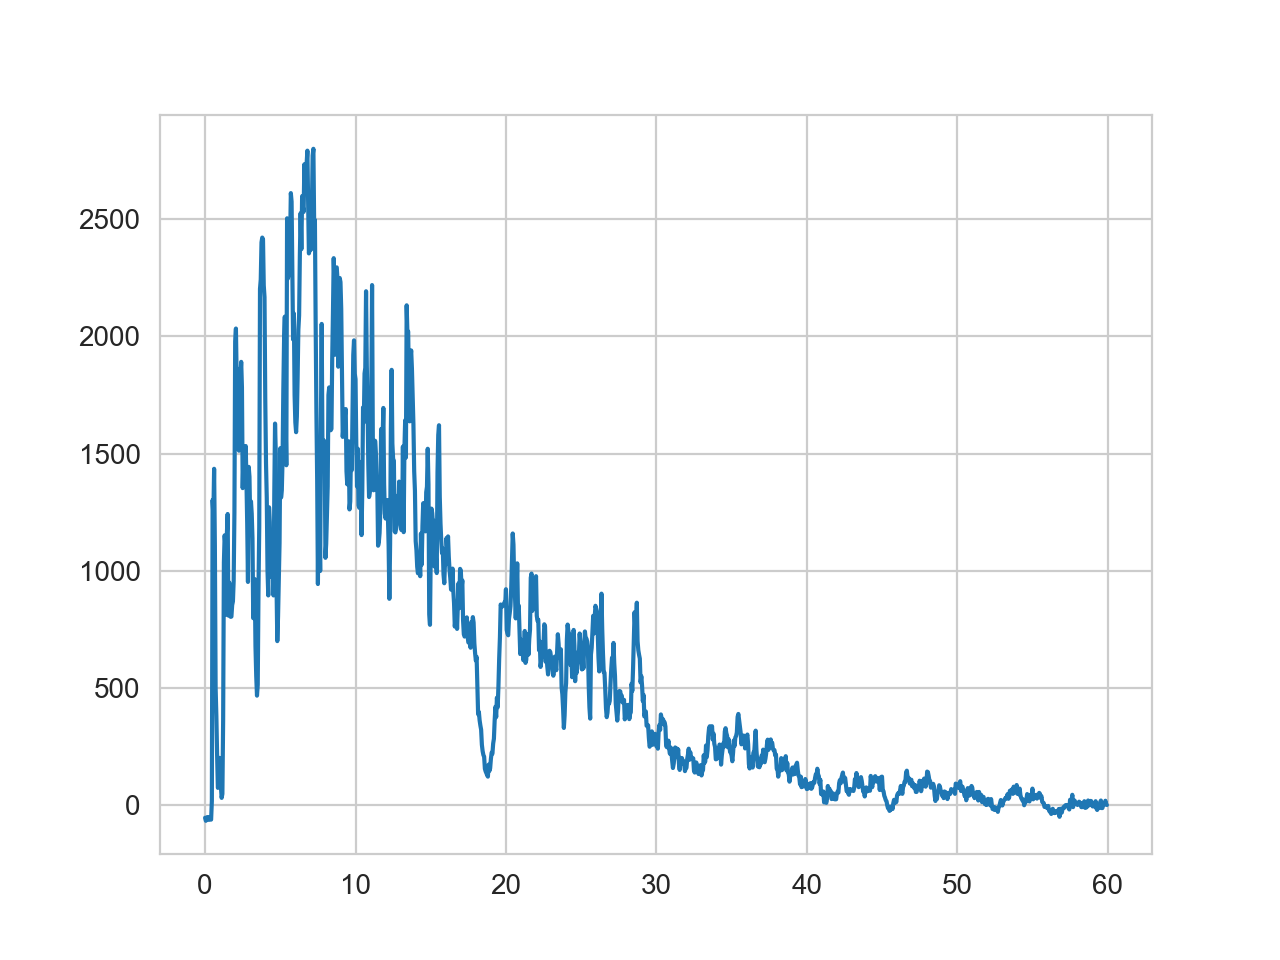

In [39]:
plt.figure()
plt.plot(lc.time, lc.counts)

In [40]:
tstart = barytime[0]

minind = barytime.searchsorted(barytime[0]+24.5)
maxind = barytime.searchsorted(barytime[0] + 84.5)

lc = Lightcurve.make_lightcurve(barytime[minind:maxind], dt=0.05)

cutout_minind = lc.time.searchsorted(tstart + 24.5 + 4.0)
cutout_maxind = lc.time.searchsorted(tstart + 24.5 + 8.0)

t1 = lc.time[:cutout_minind]
t2 = lc.time[cutout_maxind:]

time = np.hstack([t1, t2])

c1 = lc.counts[:cutout_minind]
c2 = lc.counts[cutout_maxind:]

counts = np.hstack([c1, c2])

print(time)

mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(time - time[0], counts-mean_bkg)

INFO[2023-11-06 12:07:39,256]: make_lightcurve: tseg: 59.99947488307953
INFO[2023-11-06 12:07:39,256]: make_lightcurve: timebin:  1199
INFO[2023-11-06 12:07:39,284]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-06 12:07:39,285]: Checking if light curve is sorted.
INFO[2023-11-06 12:07:39,286]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


[6.99896631e+08 6.99896631e+08 6.99896631e+08 ... 6.99896690e+08
 6.99896691e+08 6.99896691e+08]


<IPython.core.display.Javascript object>


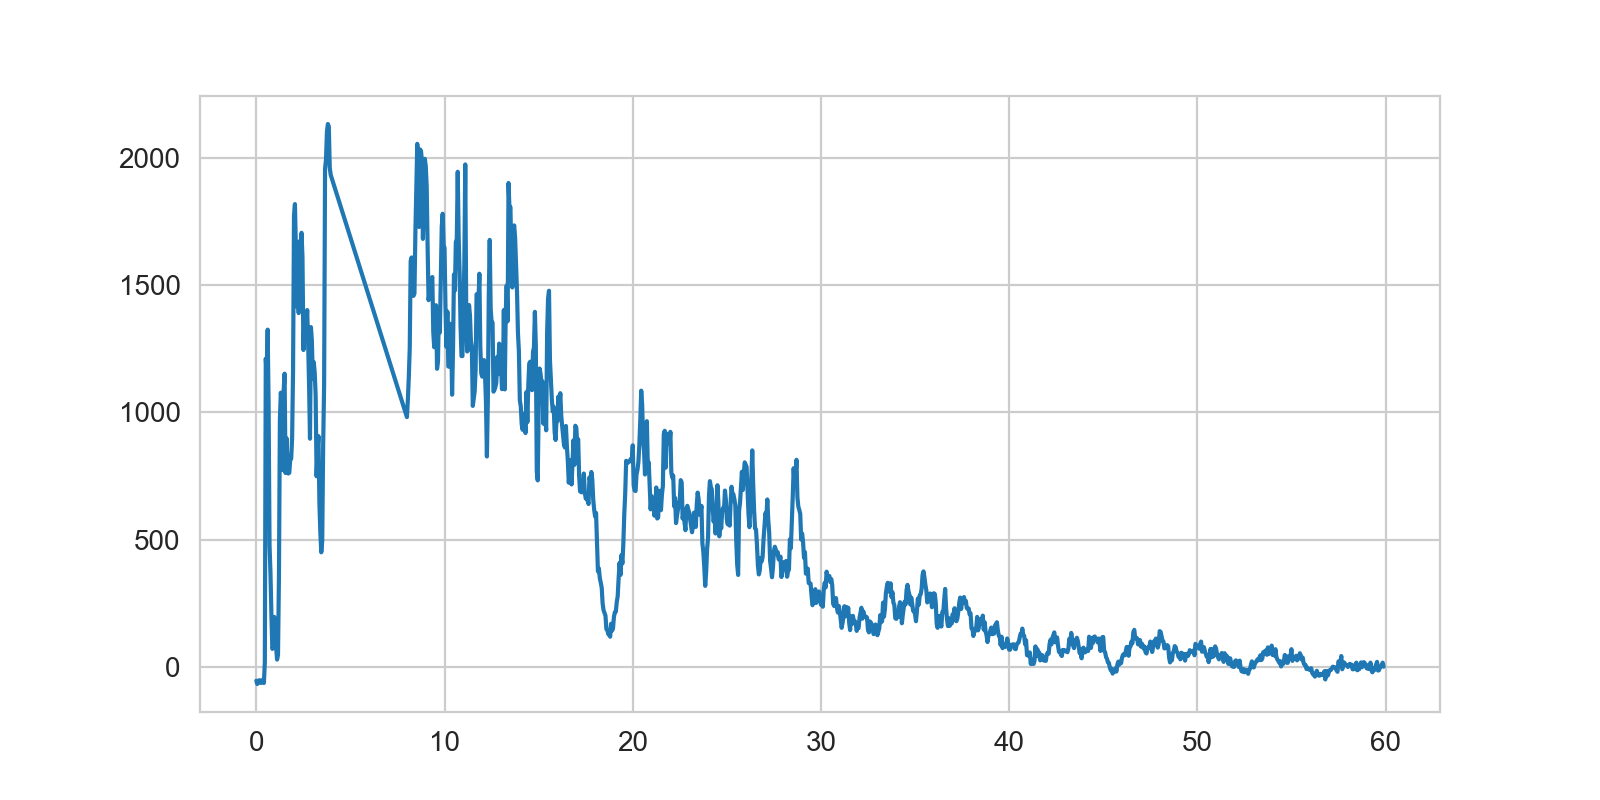

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.counts)

### DRW on Data with Cutout

In [42]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [43]:
# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    #"log_aqpo": tfpd.Uniform(2, 25),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}


params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc.time, counts = lc.counts)

In [44]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn_cutout = GPResult(lc = lc)
gpresult_rn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

INFO[2023-11-06 12:07:45,403]: Sanity check...
INFO[2023-11-06 12:07:45,409]: Sanity check passed


Simulation Complete


In [45]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -7542.558665594181


In [46]:
with open(datadir+"fermi_na_drw_cutout_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn_cutout.results, f)

In [47]:
gpresult_rn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1779586
# samples: 15500
# slices: 243000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 114.8
# likelihood evals / slice: 7.3
--------
logZ=-6737.51 +- 0.21
H=6700.0
ESS=2020
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.288 +- 0.054 | 7.221 / 7.289 / 7.357 | 7.301 | 7.301
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 10.75 +- 0.14 | 10.57 / 10.73 / 10.93 | 10.66 | 10.66
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.83 +- 0.15 | 0.65 / 0.84 / 1.02 | 0.93 | 0.93
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: 0.45 +- 0.34 | 0.06 / 0.4 / 0.89 | -0.04 | -0.04
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.724 +- 0.077 | 2.625 / 2.729 / 2.814 

<IPython.core.display.Javascript object>


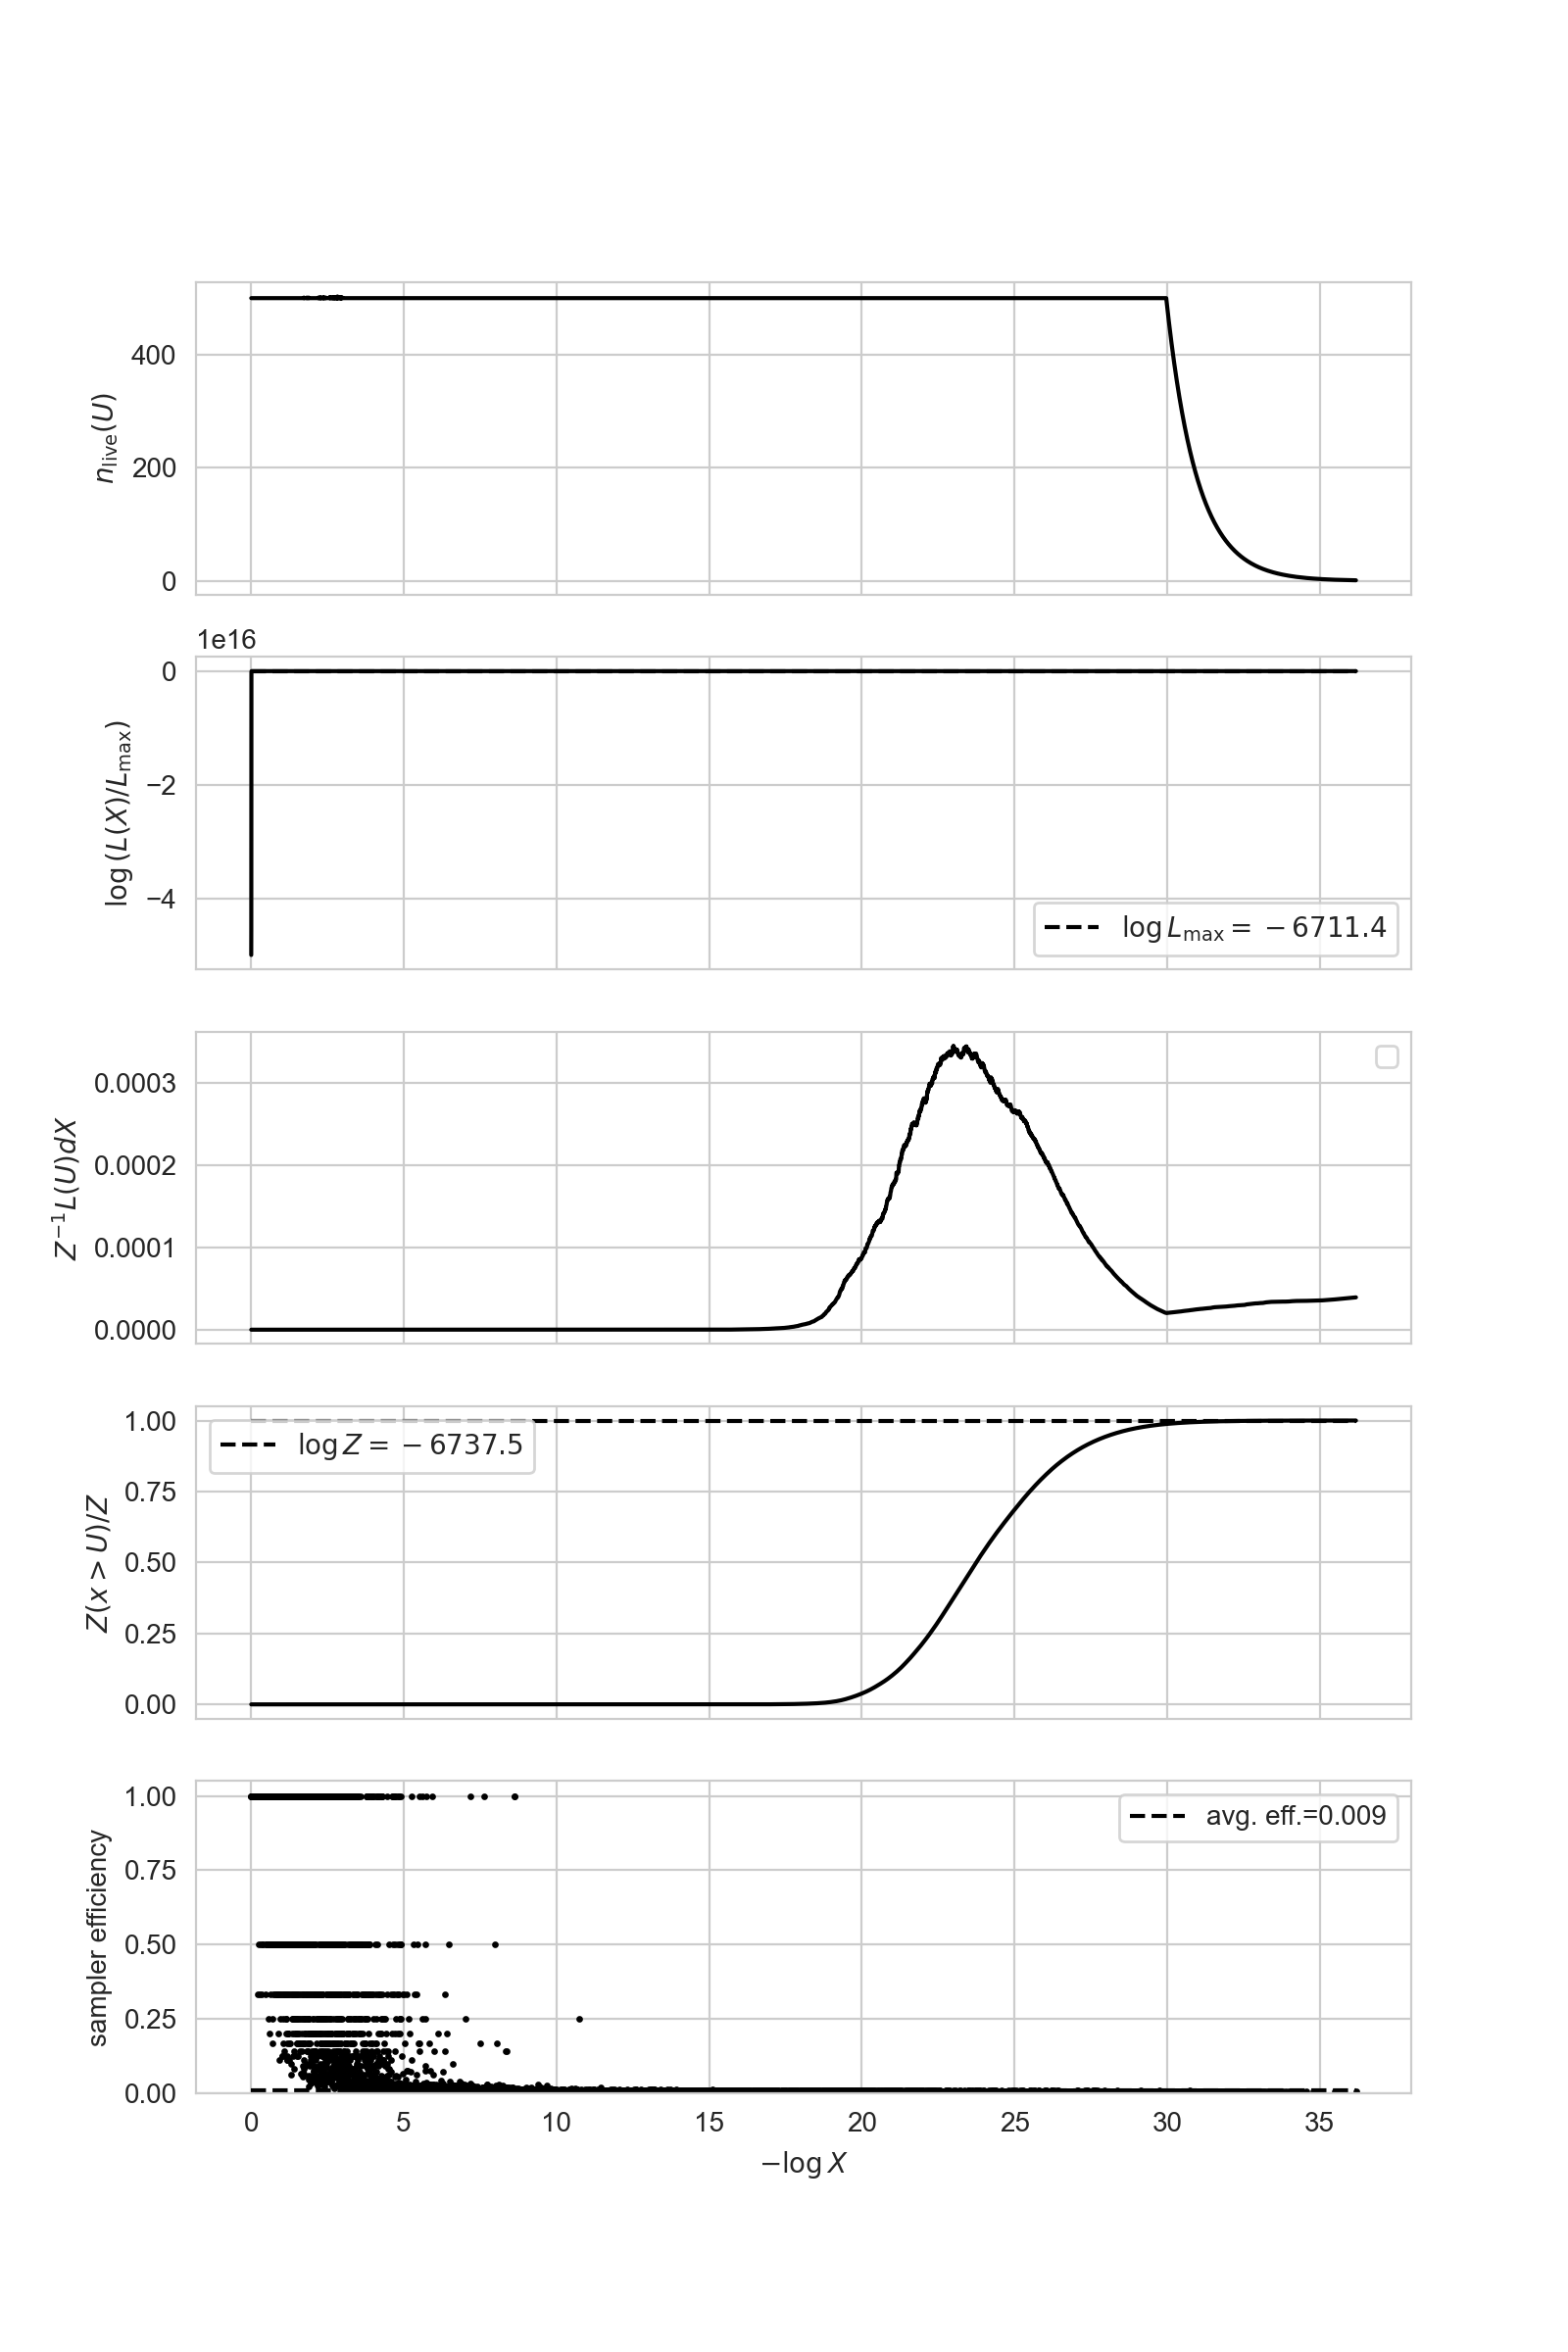

WARNING[2023-11-06 15:33:29,565]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [48]:
gpresult_rn_cutout.exact_ns.plot_diagnostics(gpresult_rn_cutout.results)

<IPython.core.display.Javascript object>


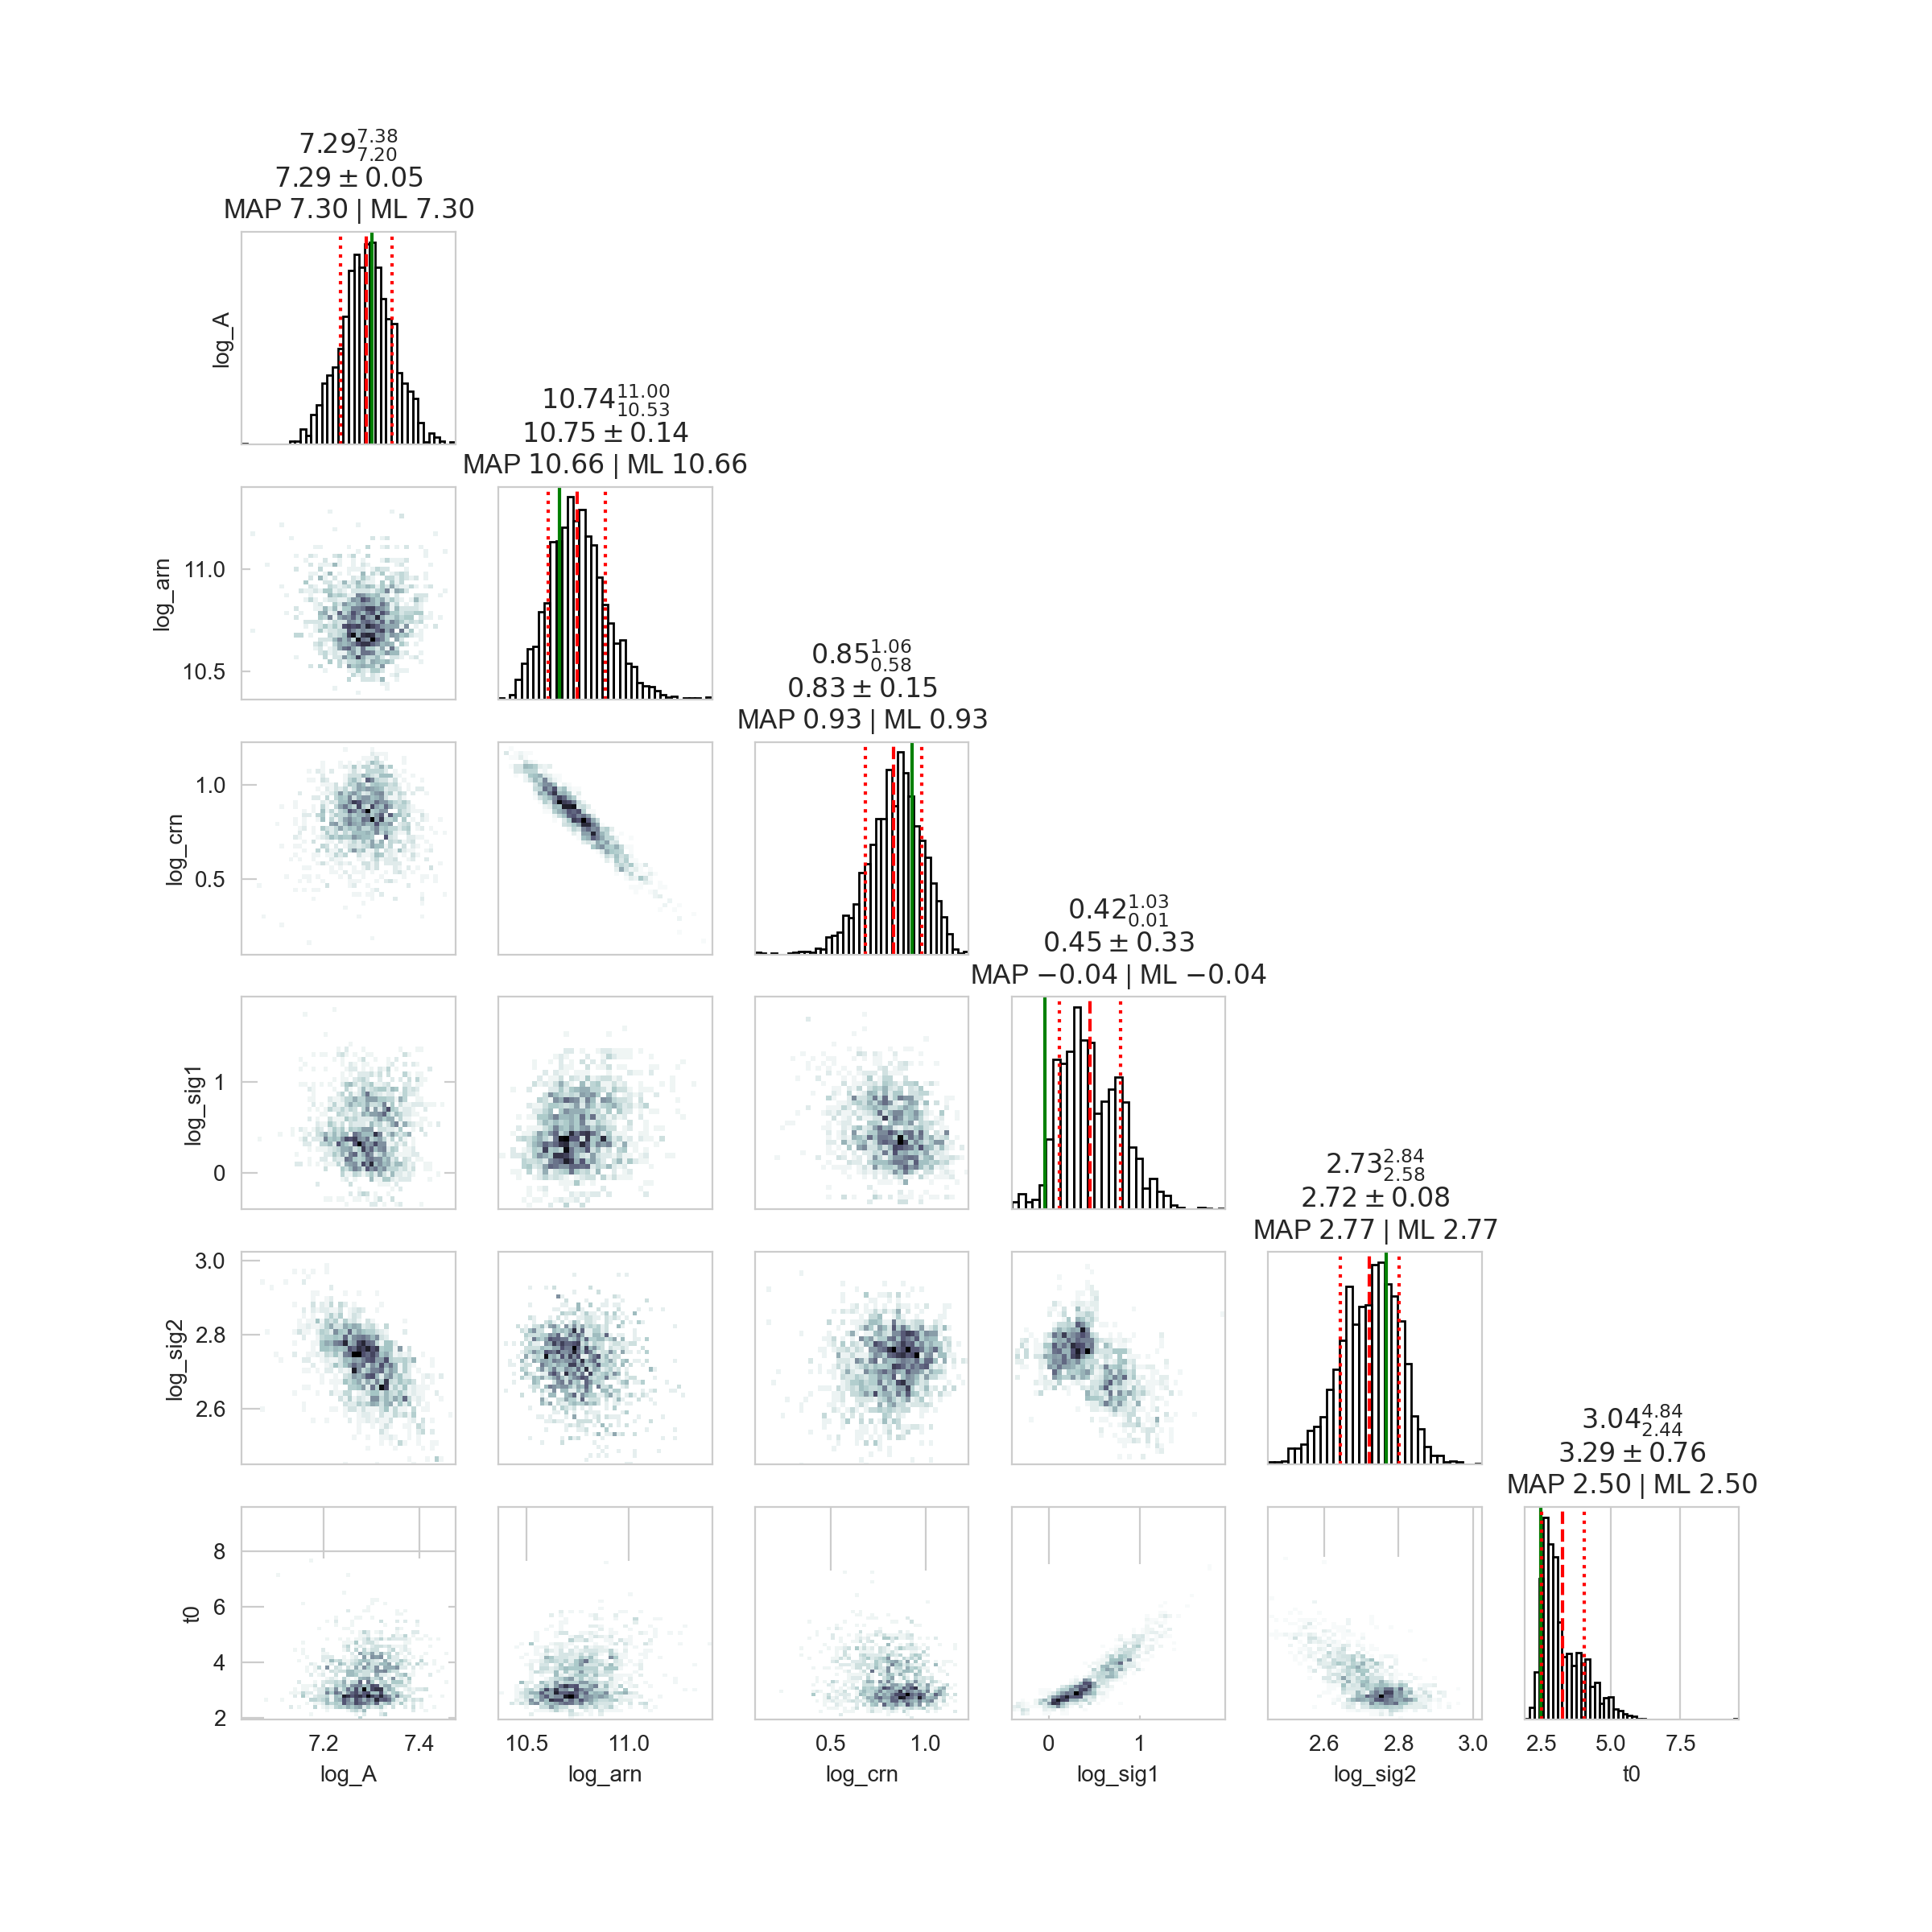

In [50]:
gpresult_rn_cutout.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


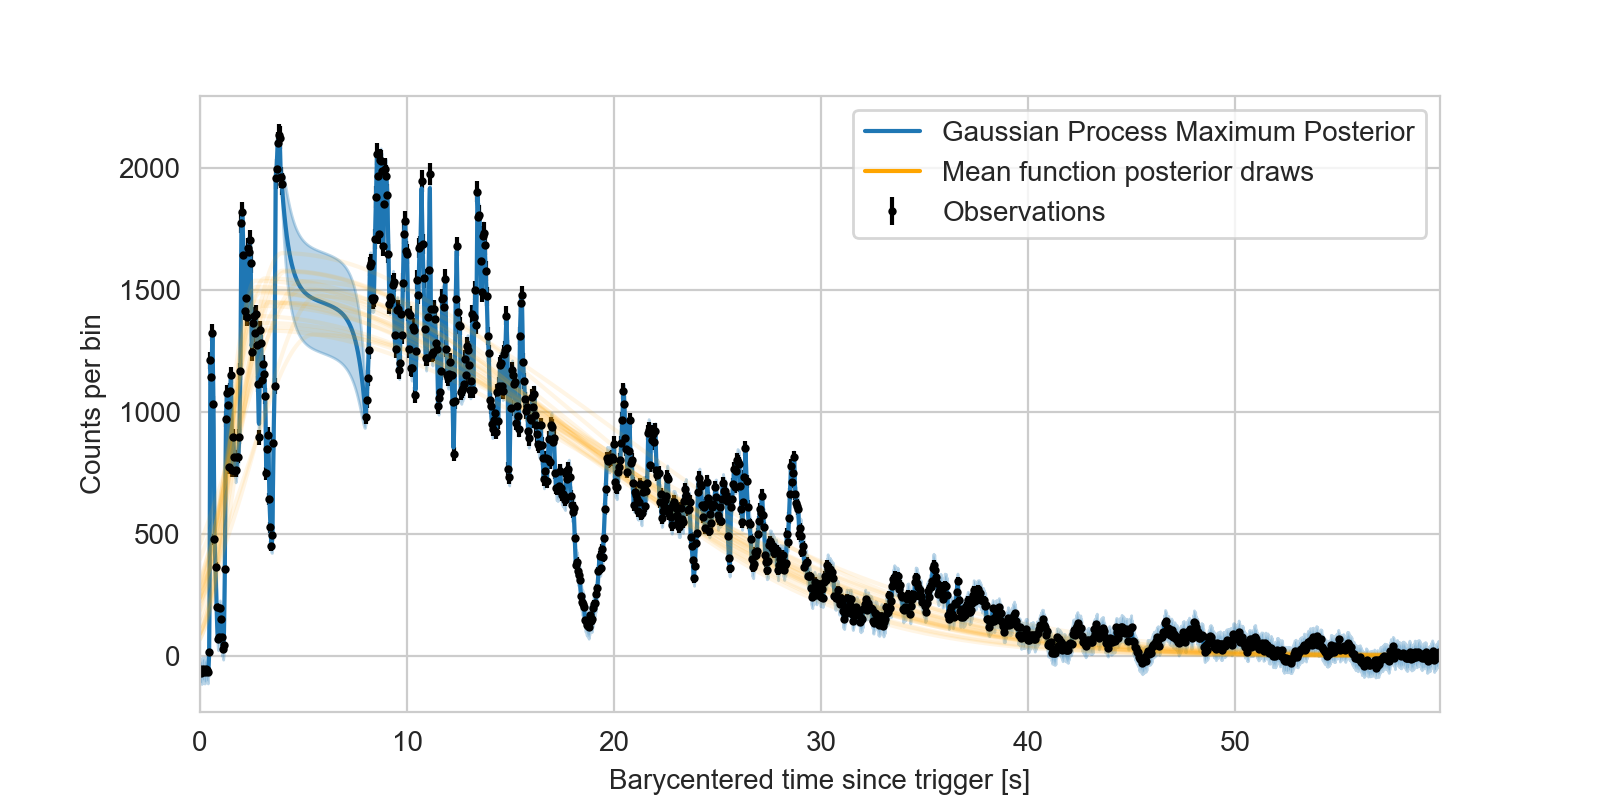

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### QPO Model, Cut-out Data

In [52]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [53]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc.time, counts = lc.counts)

In [54]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn_cutout = GPResult(lc = lc)
gpresult_qporn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2000)

INFO[2023-11-06 15:34:43,152]: Sanity check...
INFO[2023-11-06 15:34:43,159]: Sanity check passed


Simulation Complete


In [73]:
print("log Evidence: ", gpresult_rn_cutout.get_evidence())

log Evidence:  -6737.509080784273


In [74]:
print("log Evidence: ", gpresult_qporn_cutout.get_evidence())

log Evidence:  -6724.69005475332


In [75]:
gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()

Array(12.81902603, dtype=float64)

In [55]:
with open(datadir+"fermi_nai_drw_qpo_cutout_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn_cutout.results, f)

In [56]:
gpresult_qporn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 14318452
# samples: 84000
# slices: 2052000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 170.5
# likelihood evals / slice: 7.0
--------
logZ=-6724.69 +- 0.13
H=6700.0
ESS=10541
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.324 +- 0.057 | 7.253 / 7.323 / 7.397 | 7.303 | 7.303
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 9.1 +- 1.5 | 7.1 / 9.1 / 11.2 | 7.3 | 7.3
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 10.76 +- 0.16 | 10.57 / 10.75 / 10.97 | 10.61 | 10.61
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -5.3 +- 1.8 | -7.5 / -5.7 / -2.7 | -3.5 | -3.5
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.73 +- 0.17 | 0.52 / 0.75 / 0.93 | 0.88 | 0

<IPython.core.display.Javascript object>


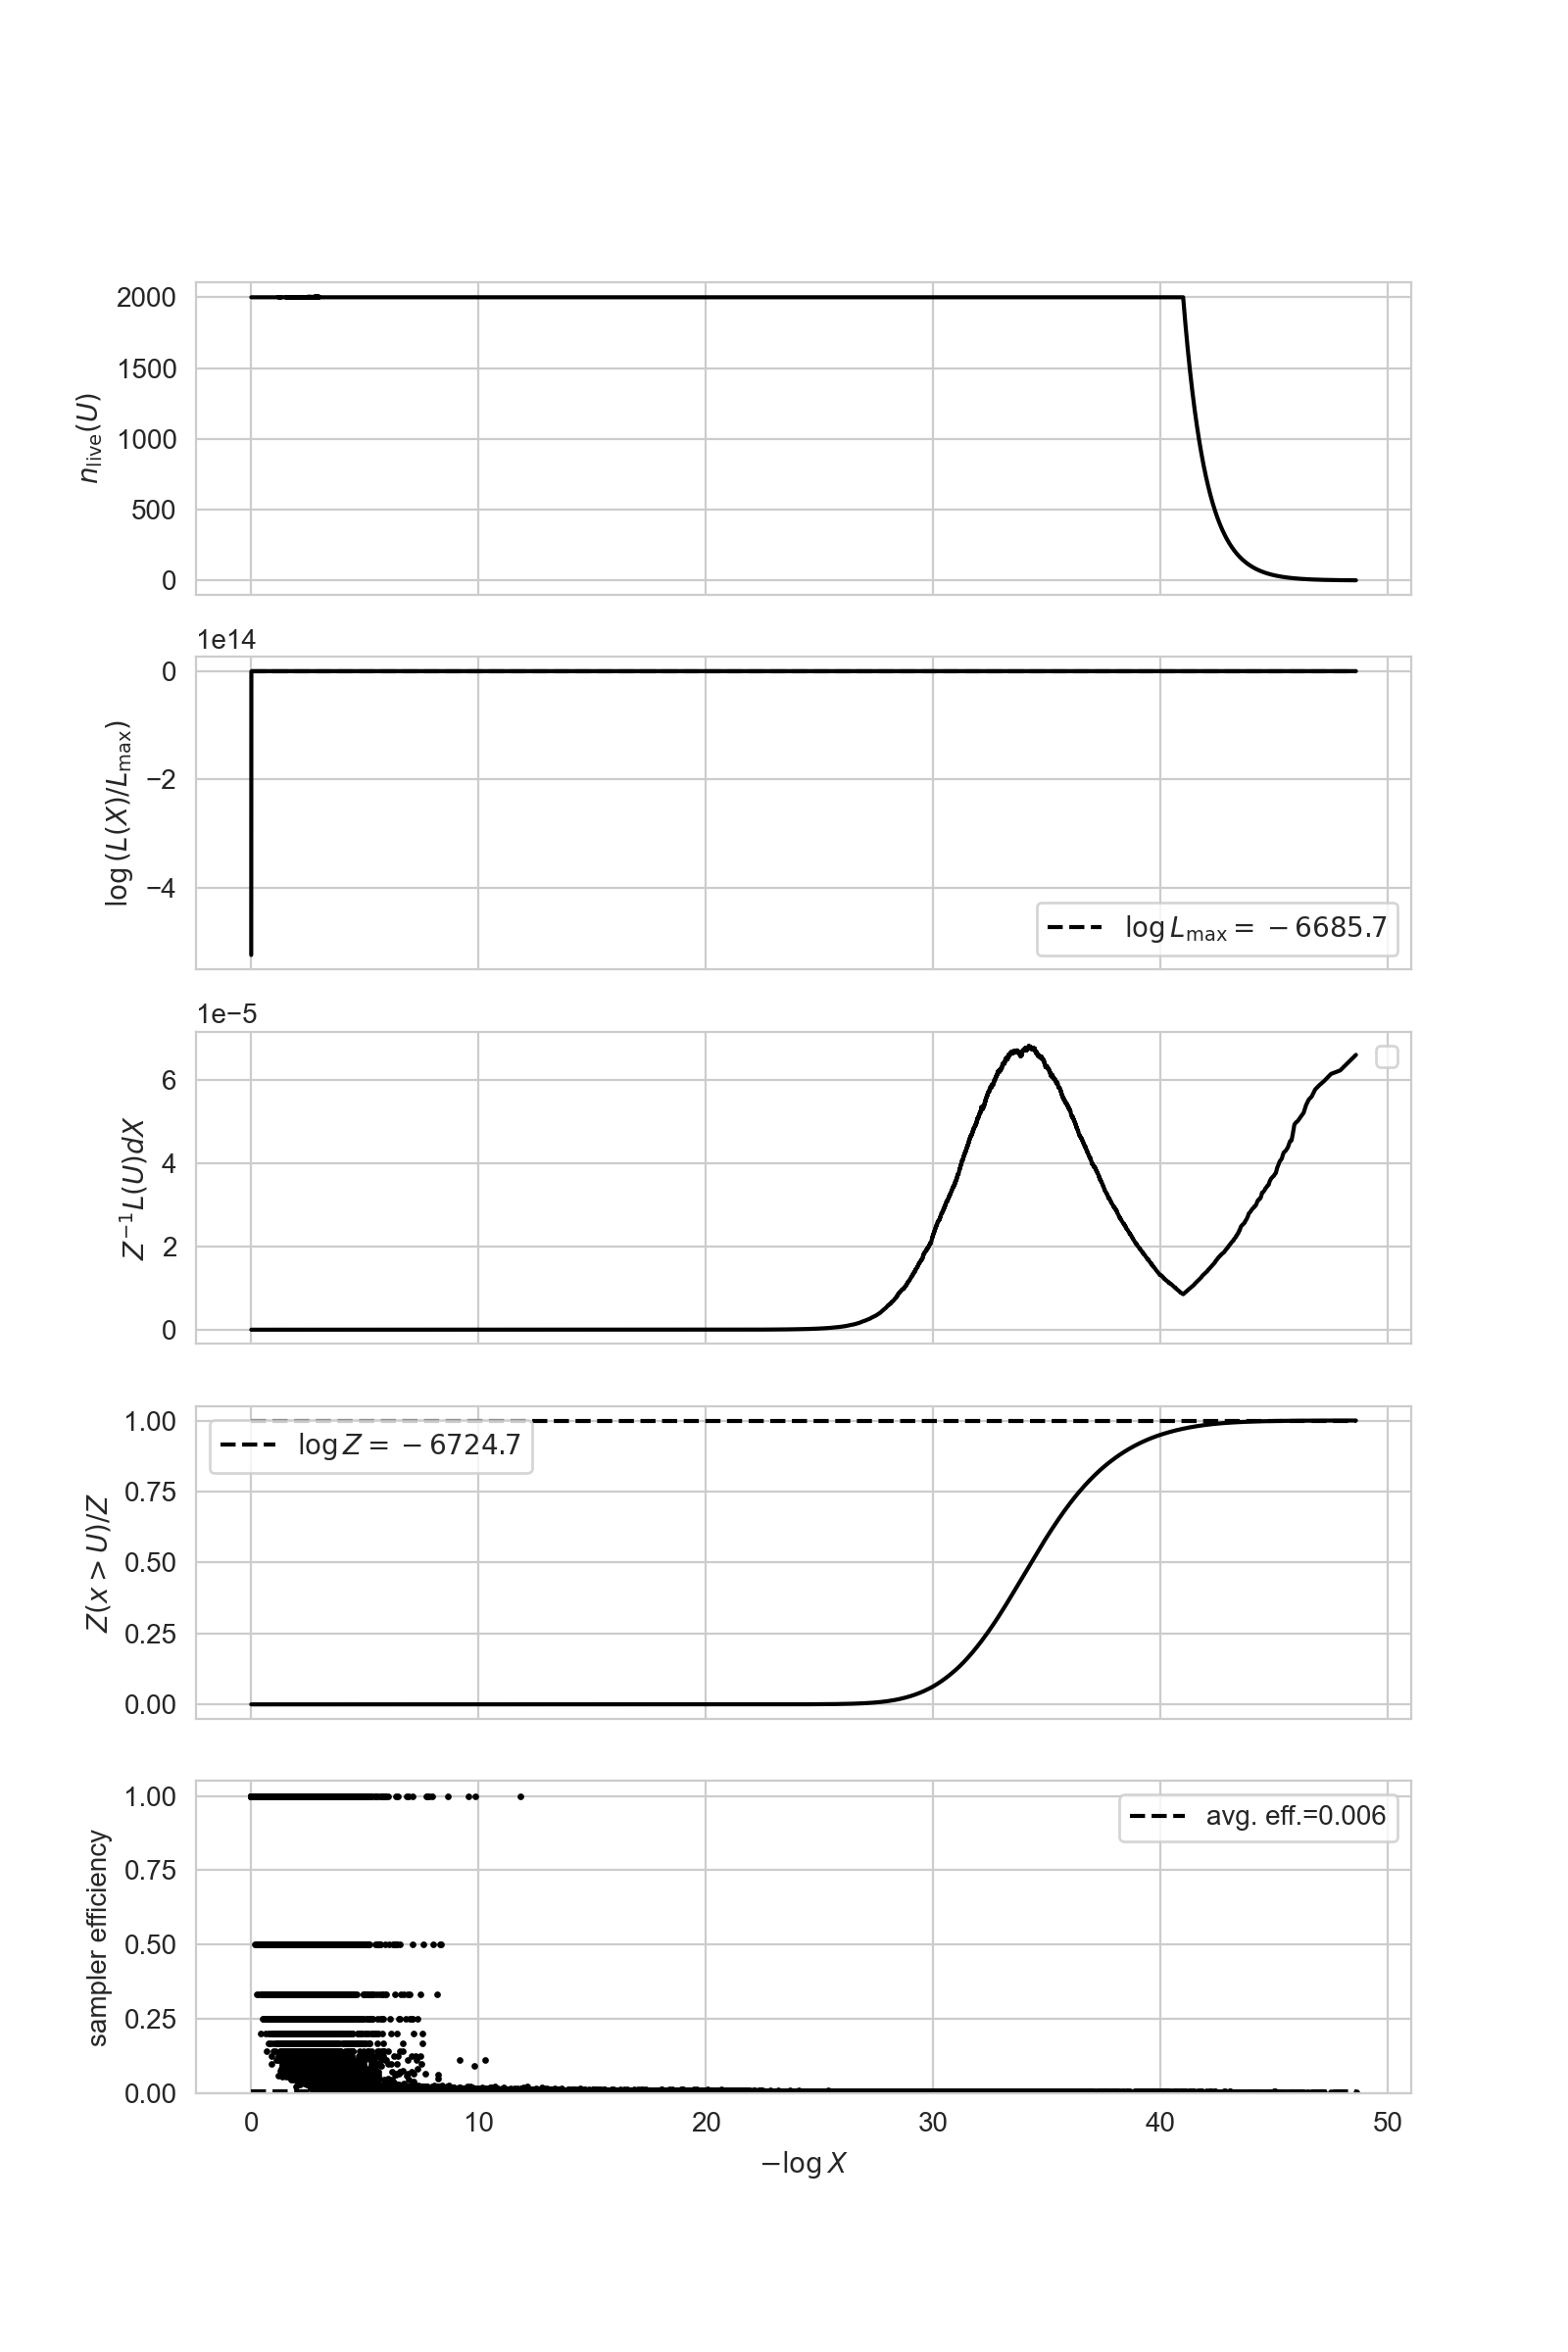

WARNING[2023-11-06 16:44:23,292]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [57]:
gpresult_qporn_cutout.exact_ns.plot_diagnostics(gpresult_qporn_cutout.results)

<IPython.core.display.Javascript object>


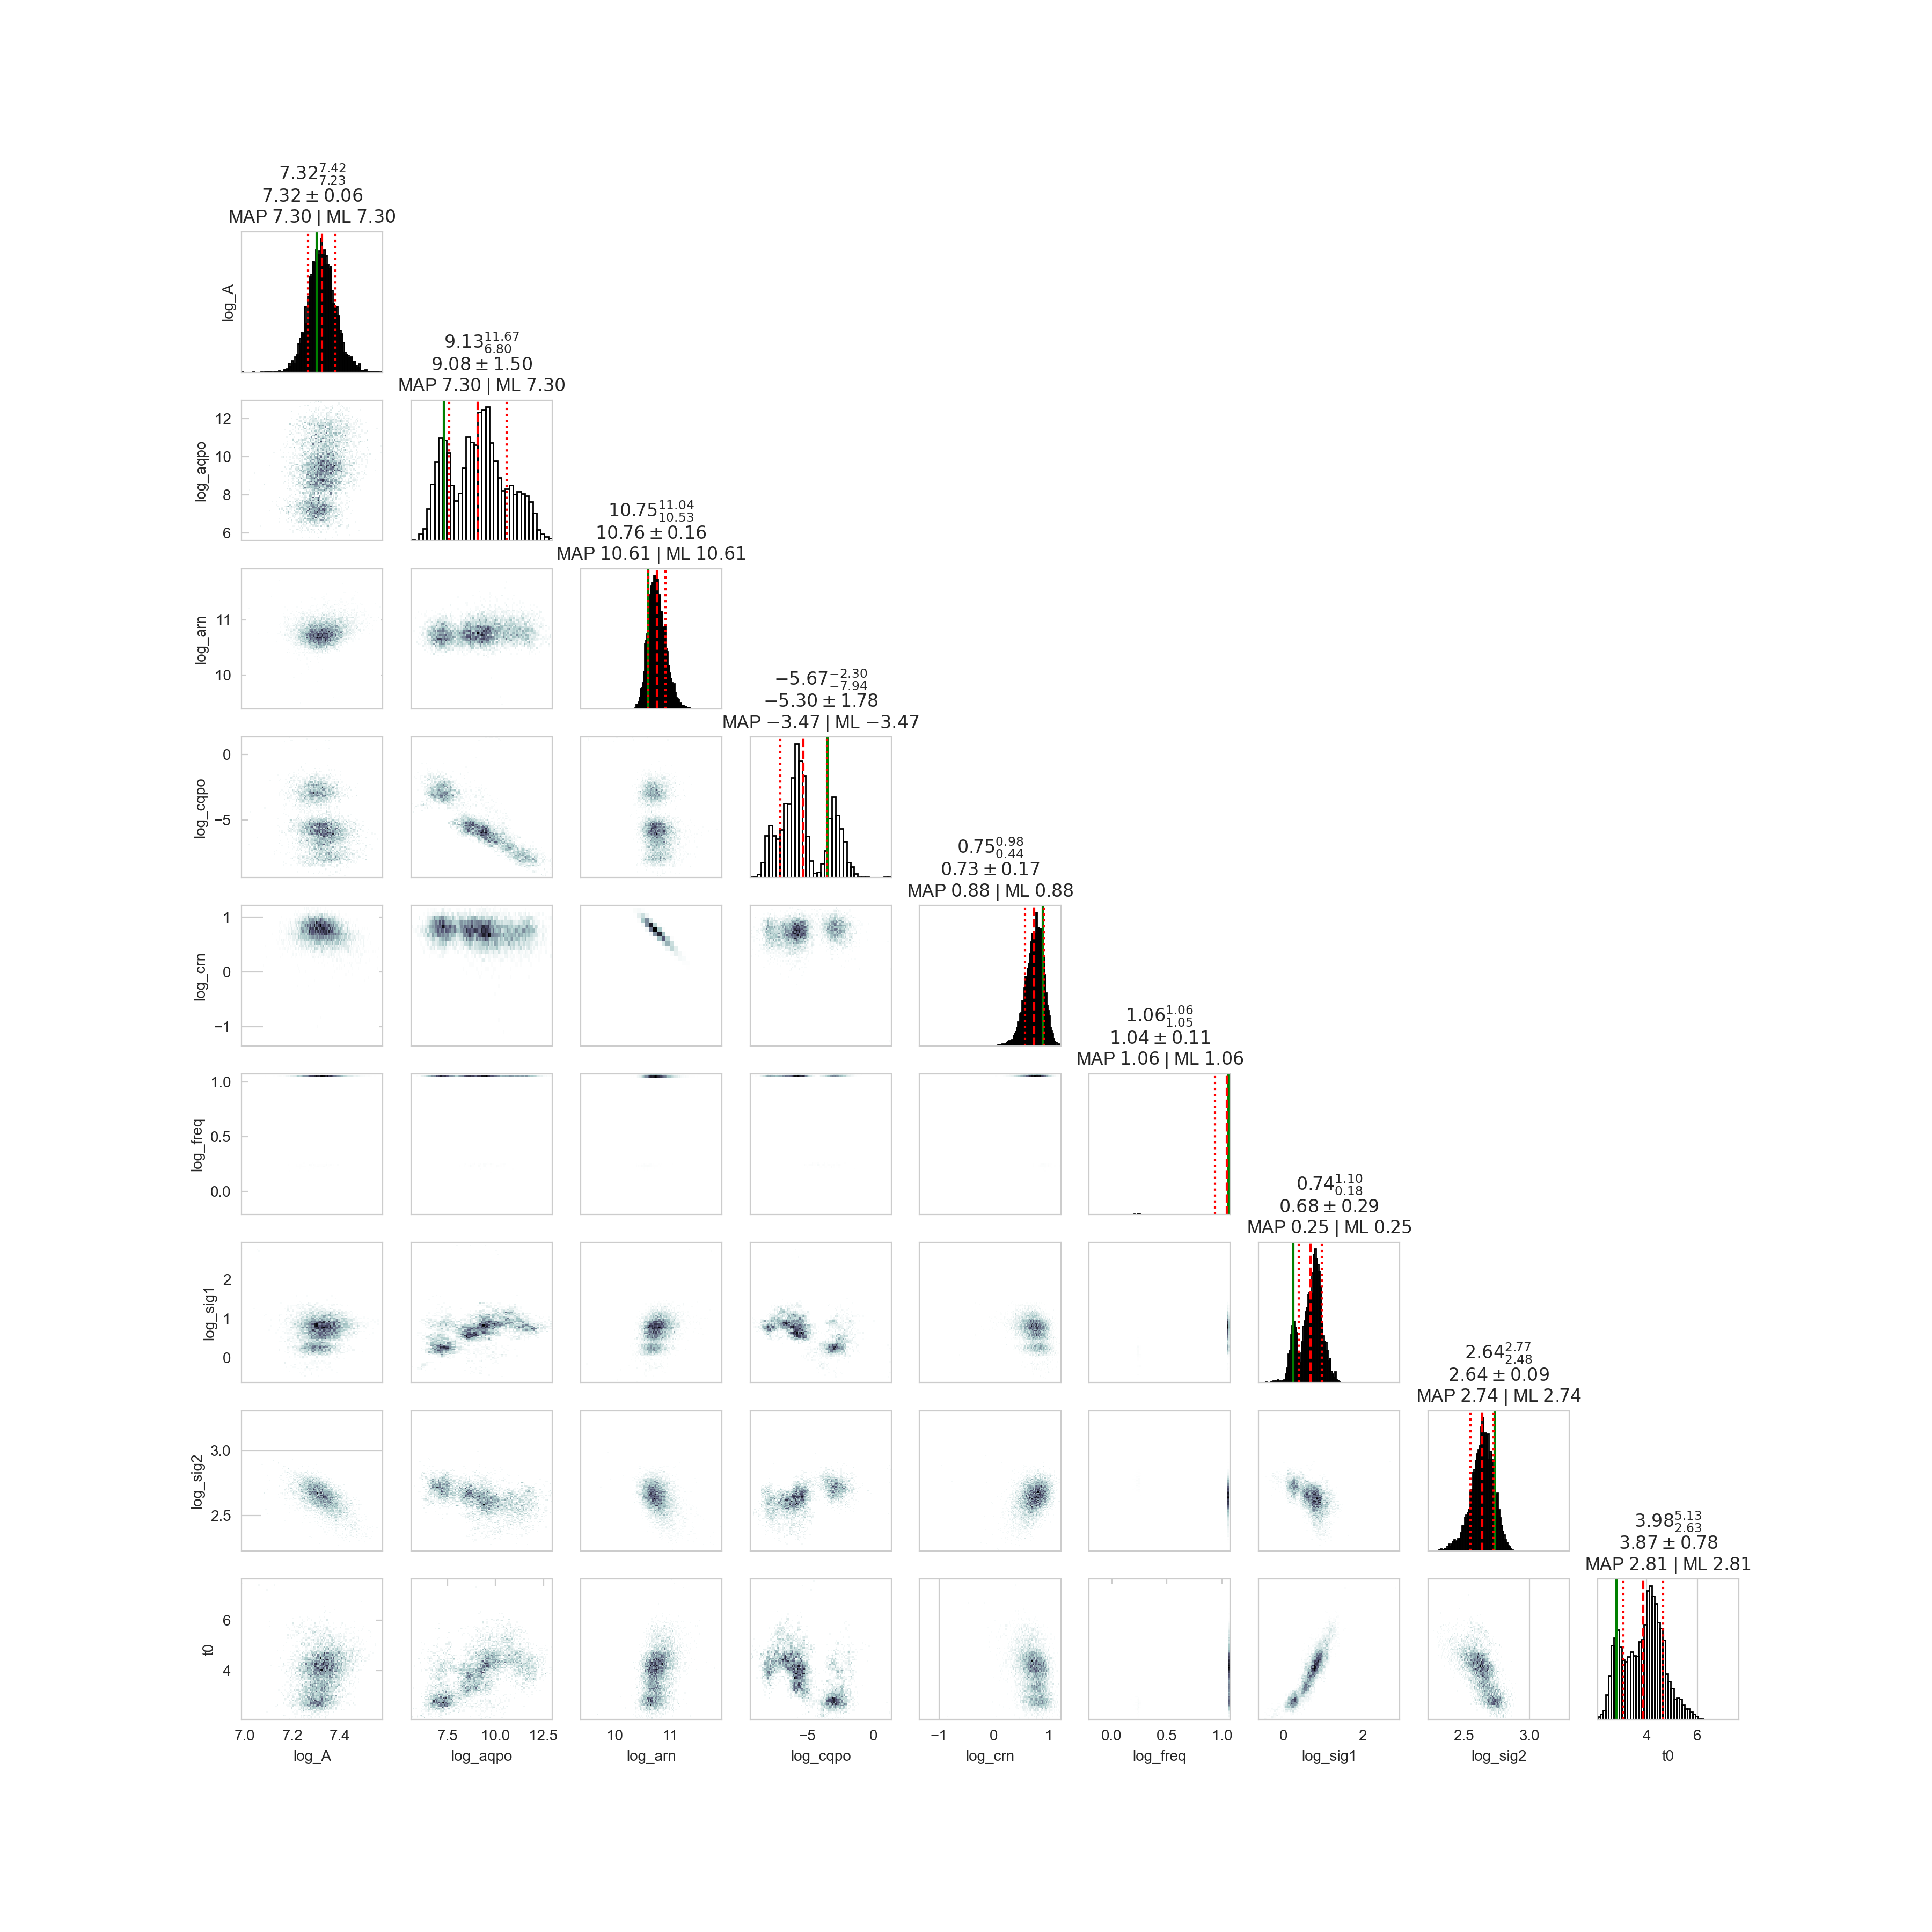

In [59]:
gpresult_qporn_cutout.plot_cornerplot()

<IPython.core.display.Javascript object>


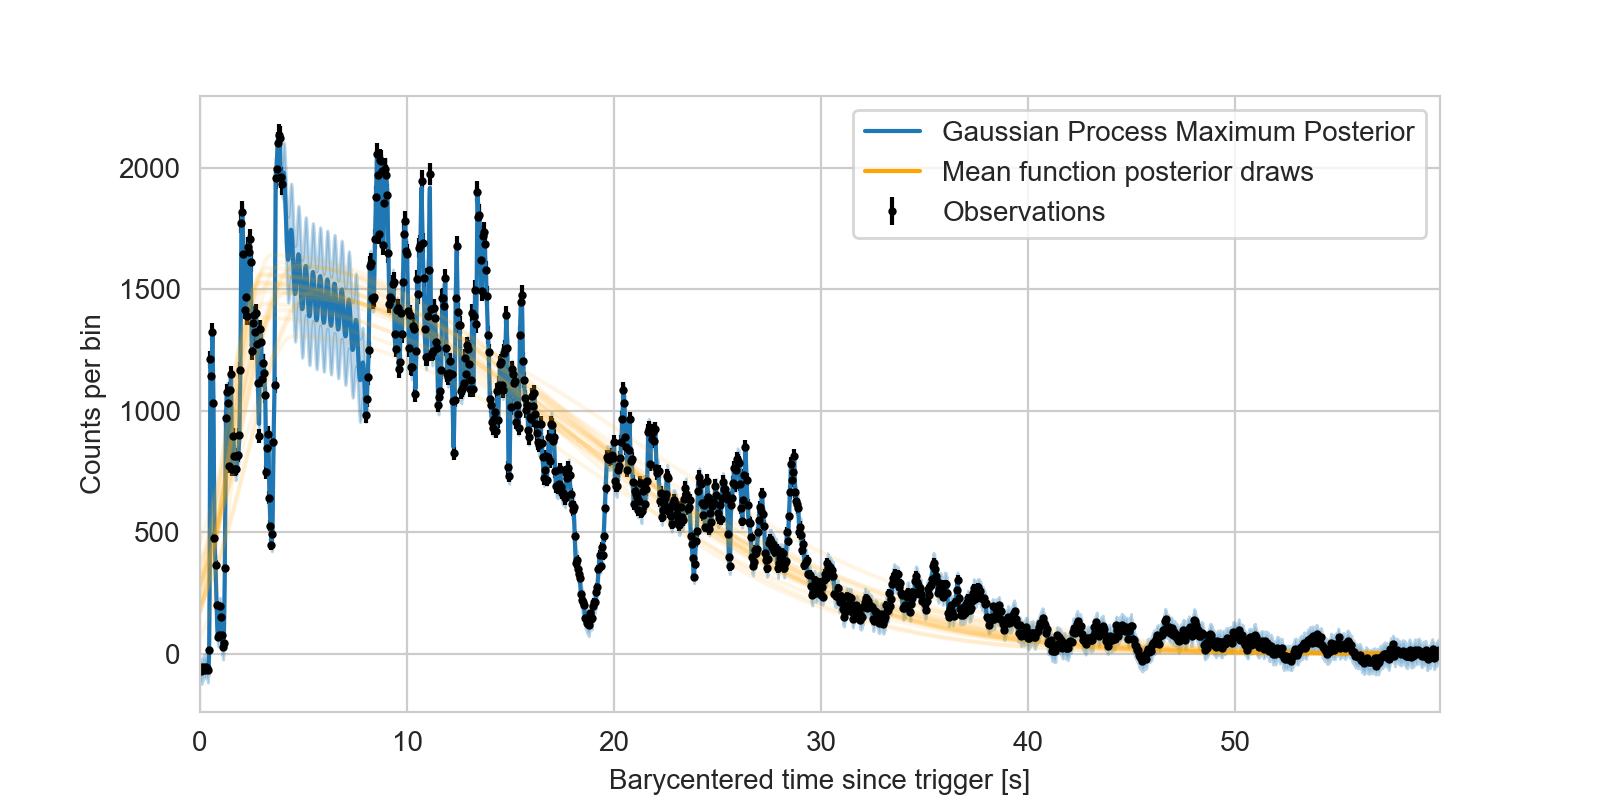

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

<IPython.core.display.Javascript object>


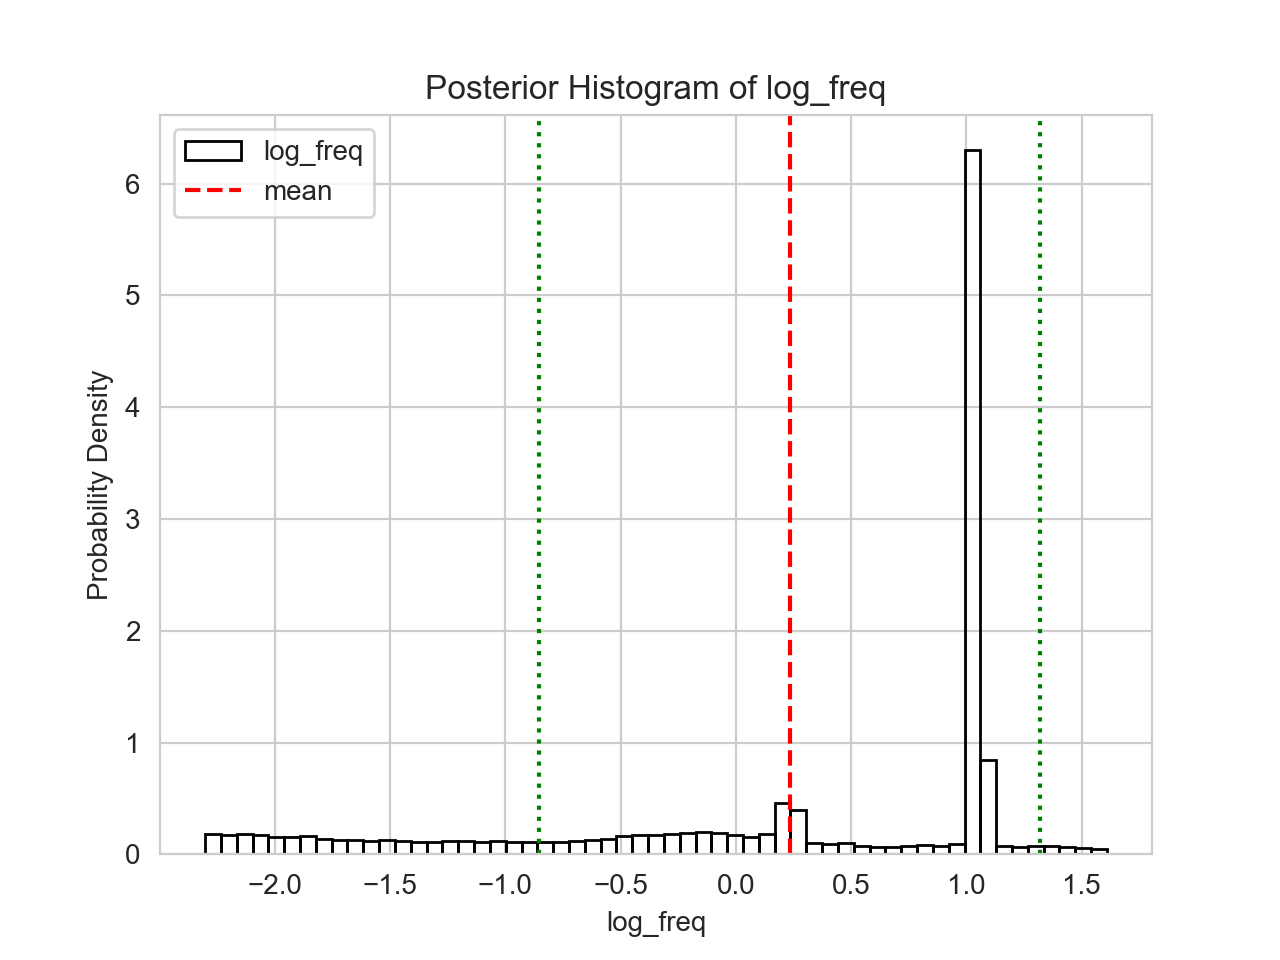

<module 'matplotlib.pyplot' from '/opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [61]:
plt.figure()
gpresult_qporn_cutout.posterior_plot("log_freq")

In [62]:
samples = gpresult_qporn_cutout.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn_cutout.results.log_dp_mean #log-prob
nsamples = gpresult_qporn_cutout.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn_cutout.results.ESS)), replace=True
)

In [63]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [64]:
period

array([0.3480389 , 0.34777027, 0.3485801 , ..., 0.34686484, 0.34833166,
       0.3486024 ])

<IPython.core.display.Javascript object>


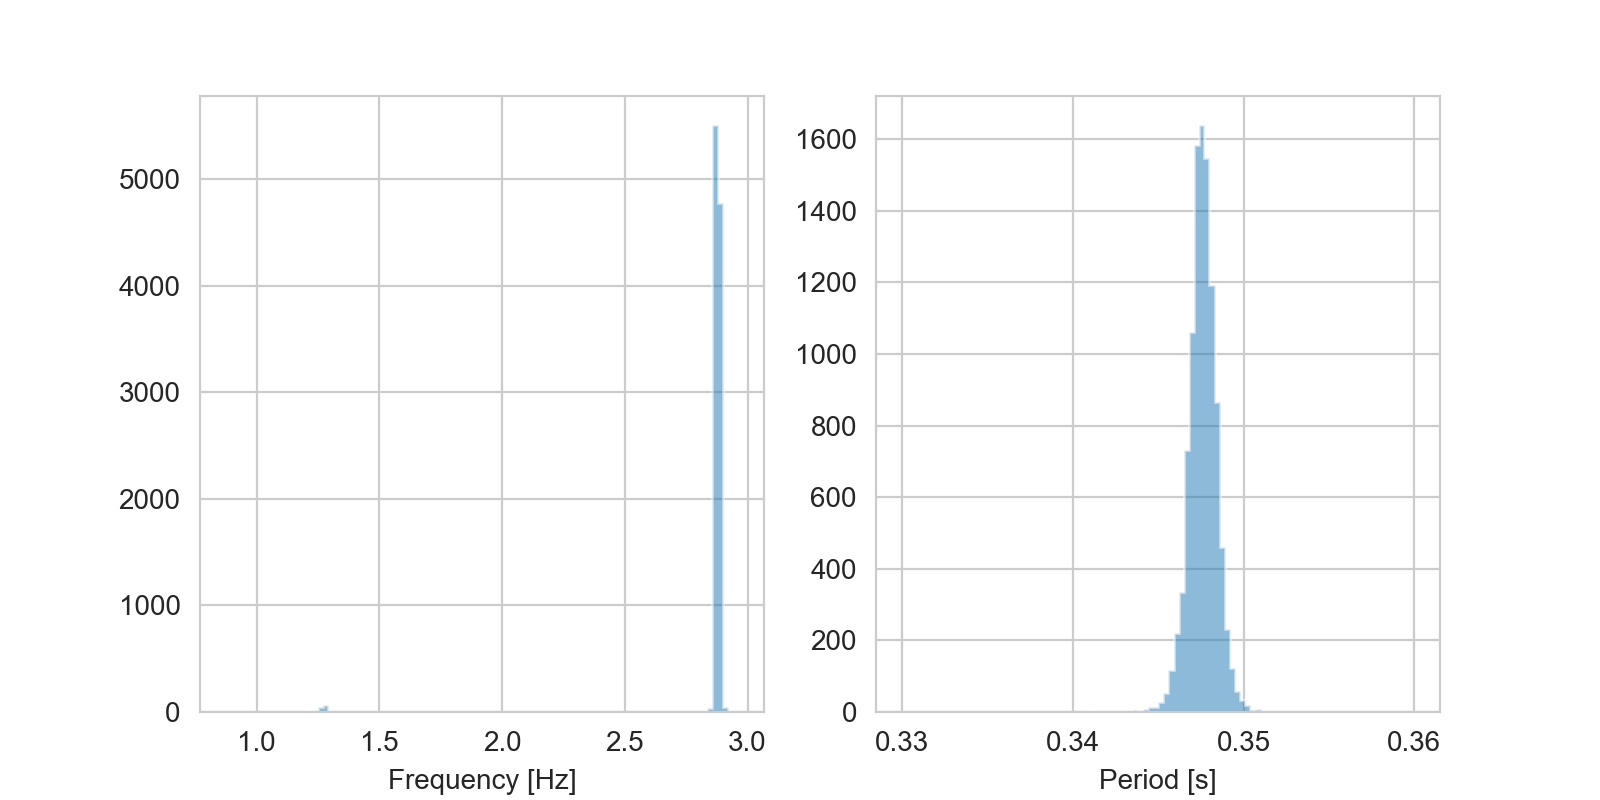

Text(0.5, 0, 'Period [s]')

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

histrange = [0.33, 0.36]
ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5, range=histrange)
ax2.set_xlabel("Period [s]")

In [67]:
np.log10(np.exp(gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()))

5.567232268617012

... and I'm done with this analysis!